In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer

In [2]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 4800)
(1865, 3)


In [5]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

2022-03-03 10:30:33.115175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

(array([354.,  70.,  48.,  48.,  50.,  37.,  79.,  93., 176., 910.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

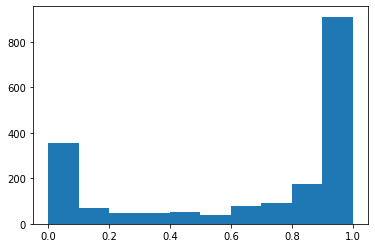

In [7]:
plt.hist(qc)

In [8]:
# plt.scatter(y, qc, alpha=0.1)

In [9]:
X.shape

(1865, 100, 48)

In [10]:
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel

In [11]:
# Split the data into train and test sets:
X_train, X_test, y_train, y_test, qc_train, qc_test, site_train, site_test = train_test_split(X, y, qc, site, test_size=0.2, random_state=42)

In [12]:
imputer = SimpleImputer(strategy="median")

In [13]:
# Impute train and test separately:
X_train = np.concatenate([imputer.fit_transform(X_train[..., ii])[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([imputer.fit_transform(X_test[..., ii])[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [14]:
# Combat
X_train = np.concatenate([CombatModel().fit_transform(X_train[..., ii], site_train[:, None], None, None)[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([CombatModel().fit_transform(X_test[..., ii], site_test[:, None], None, None)[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [15]:
X_train.shape, X_test.shape

((1492, 100, 48), (373, 100, 48))

#### cnn_LeNet model, epoch = 500

In [19]:
model_cnn_lenet = cnn_lenet(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_cnn_lenet.compile(loss='mean_squared_error', optimizer="adam", metrics=['mean_squared_error'])
history_lenet = model_cnn_lenet.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

pooling layers: 4
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 100, 6)            870       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 50, 6)            0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 50, 16)            304       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 25, 16)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 25, 2

10/10 [==============================] - 0s 17ms/step - loss: 16.9575 - mean_squared_error: 16.9575 - val_loss: 11.6409 - val_mean_squared_error: 11.6409
Epoch 35/500
10/10 [==============================] - 0s 17ms/step - loss: 17.3463 - mean_squared_error: 17.3463 - val_loss: 11.4594 - val_mean_squared_error: 11.4594
Epoch 36/500
10/10 [==============================] - 0s 17ms/step - loss: 15.8713 - mean_squared_error: 15.8713 - val_loss: 11.4301 - val_mean_squared_error: 11.4301
Epoch 37/500
10/10 [==============================] - 0s 17ms/step - loss: 16.3716 - mean_squared_error: 16.3716 - val_loss: 11.8010 - val_mean_squared_error: 11.8010
Epoch 38/500
10/10 [==============================] - 0s 17ms/step - loss: 16.7998 - mean_squared_error: 16.7998 - val_loss: 11.5735 - val_mean_squared_error: 11.5735
Epoch 39/500
10/10 [==============================] - 0s 17ms/step - loss: 16.2300 - mean_squared_error: 16.2300 - val_loss: 11.1977 - val_mean_squared_error: 11.1977
Epoch 40/50

10/10 [==============================] - 0s 17ms/step - loss: 12.3375 - mean_squared_error: 12.3375 - val_loss: 8.4474 - val_mean_squared_error: 8.4474
Epoch 84/500
10/10 [==============================] - 0s 17ms/step - loss: 12.2302 - mean_squared_error: 12.2302 - val_loss: 10.1767 - val_mean_squared_error: 10.1767
Epoch 85/500
10/10 [==============================] - 0s 17ms/step - loss: 12.2538 - mean_squared_error: 12.2538 - val_loss: 10.9203 - val_mean_squared_error: 10.9203
Epoch 86/500
10/10 [==============================] - 0s 19ms/step - loss: 12.1957 - mean_squared_error: 12.1957 - val_loss: 9.4818 - val_mean_squared_error: 9.4818
Epoch 87/500
10/10 [==============================] - 0s 17ms/step - loss: 11.9681 - mean_squared_error: 11.9681 - val_loss: 8.7609 - val_mean_squared_error: 8.7609
Epoch 88/500
10/10 [==============================] - 0s 17ms/step - loss: 11.7103 - mean_squared_error: 11.7103 - val_loss: 8.4805 - val_mean_squared_error: 8.4805
Epoch 89/500
10/10 

10/10 [==============================] - 0s 18ms/step - loss: 9.3949 - mean_squared_error: 9.3949 - val_loss: 8.0365 - val_mean_squared_error: 8.0365
Epoch 133/500
10/10 [==============================] - 0s 17ms/step - loss: 9.3344 - mean_squared_error: 9.3344 - val_loss: 7.6105 - val_mean_squared_error: 7.6105
Epoch 134/500
10/10 [==============================] - 0s 17ms/step - loss: 9.8376 - mean_squared_error: 9.8376 - val_loss: 7.7035 - val_mean_squared_error: 7.7035
Epoch 135/500
10/10 [==============================] - 0s 18ms/step - loss: 10.0062 - mean_squared_error: 10.0062 - val_loss: 7.6592 - val_mean_squared_error: 7.6592
Epoch 136/500
10/10 [==============================] - 0s 17ms/step - loss: 9.6165 - mean_squared_error: 9.6165 - val_loss: 7.4290 - val_mean_squared_error: 7.4290
Epoch 137/500
10/10 [==============================] - 0s 18ms/step - loss: 9.4673 - mean_squared_error: 9.4673 - val_loss: 8.0168 - val_mean_squared_error: 8.0168
Epoch 138/500
10/10 [=======

10/10 [==============================] - 0s 17ms/step - loss: 8.3987 - mean_squared_error: 8.3987 - val_loss: 9.3168 - val_mean_squared_error: 9.3168
Epoch 183/500
10/10 [==============================] - 0s 17ms/step - loss: 7.6448 - mean_squared_error: 7.6448 - val_loss: 8.0232 - val_mean_squared_error: 8.0232
Epoch 184/500
10/10 [==============================] - 0s 18ms/step - loss: 8.4495 - mean_squared_error: 8.4495 - val_loss: 8.1397 - val_mean_squared_error: 8.1397
Epoch 185/500
10/10 [==============================] - 0s 17ms/step - loss: 8.5404 - mean_squared_error: 8.5404 - val_loss: 7.6437 - val_mean_squared_error: 7.6437
Epoch 186/500
10/10 [==============================] - 0s 20ms/step - loss: 8.1346 - mean_squared_error: 8.1346 - val_loss: 7.4989 - val_mean_squared_error: 7.4989
Epoch 187/500
10/10 [==============================] - 0s 20ms/step - loss: 8.9832 - mean_squared_error: 8.9832 - val_loss: 7.6391 - val_mean_squared_error: 7.6391
Epoch 188/500
10/10 [=========

10/10 [==============================] - 0s 17ms/step - loss: 7.3137 - mean_squared_error: 7.3137 - val_loss: 7.6833 - val_mean_squared_error: 7.6833
Epoch 233/500
10/10 [==============================] - 0s 16ms/step - loss: 7.5071 - mean_squared_error: 7.5071 - val_loss: 7.5446 - val_mean_squared_error: 7.5446
Epoch 234/500
10/10 [==============================] - 0s 17ms/step - loss: 6.7450 - mean_squared_error: 6.7450 - val_loss: 7.4929 - val_mean_squared_error: 7.4929
Epoch 235/500
10/10 [==============================] - 0s 17ms/step - loss: 6.8246 - mean_squared_error: 6.8246 - val_loss: 7.5490 - val_mean_squared_error: 7.5490
Epoch 236/500
10/10 [==============================] - 0s 18ms/step - loss: 7.3042 - mean_squared_error: 7.3042 - val_loss: 7.5148 - val_mean_squared_error: 7.5148
Epoch 237/500
10/10 [==============================] - 0s 18ms/step - loss: 7.2185 - mean_squared_error: 7.2185 - val_loss: 8.0371 - val_mean_squared_error: 8.0371
Epoch 238/500
10/10 [=========

10/10 [==============================] - 0s 17ms/step - loss: 5.7161 - mean_squared_error: 5.7161 - val_loss: 7.6534 - val_mean_squared_error: 7.6534
Epoch 283/500
10/10 [==============================] - 0s 17ms/step - loss: 5.9478 - mean_squared_error: 5.9478 - val_loss: 7.9743 - val_mean_squared_error: 7.9743
Epoch 284/500
10/10 [==============================] - 0s 17ms/step - loss: 6.0741 - mean_squared_error: 6.0741 - val_loss: 8.1489 - val_mean_squared_error: 8.1489
Epoch 285/500
10/10 [==============================] - 0s 17ms/step - loss: 5.9558 - mean_squared_error: 5.9558 - val_loss: 8.0790 - val_mean_squared_error: 8.0790
Epoch 286/500
10/10 [==============================] - 0s 17ms/step - loss: 5.7549 - mean_squared_error: 5.7549 - val_loss: 7.7558 - val_mean_squared_error: 7.7558
Epoch 287/500
10/10 [==============================] - 0s 17ms/step - loss: 5.8561 - mean_squared_error: 5.8561 - val_loss: 8.2003 - val_mean_squared_error: 8.2003
Epoch 288/500
10/10 [=========

10/10 [==============================] - 0s 17ms/step - loss: 5.4302 - mean_squared_error: 5.4302 - val_loss: 8.7162 - val_mean_squared_error: 8.7162
Epoch 333/500
10/10 [==============================] - 0s 17ms/step - loss: 5.9815 - mean_squared_error: 5.9815 - val_loss: 8.7261 - val_mean_squared_error: 8.7261
Epoch 334/500
10/10 [==============================] - 0s 17ms/step - loss: 5.0662 - mean_squared_error: 5.0662 - val_loss: 8.5617 - val_mean_squared_error: 8.5617
Epoch 335/500
10/10 [==============================] - 0s 17ms/step - loss: 5.5130 - mean_squared_error: 5.5130 - val_loss: 8.5613 - val_mean_squared_error: 8.5613
Epoch 336/500
10/10 [==============================] - 0s 17ms/step - loss: 5.2915 - mean_squared_error: 5.2915 - val_loss: 9.0141 - val_mean_squared_error: 9.0141
Epoch 337/500
10/10 [==============================] - 0s 17ms/step - loss: 4.9557 - mean_squared_error: 4.9557 - val_loss: 9.8933 - val_mean_squared_error: 9.8933
Epoch 338/500
10/10 [=========

10/10 [==============================] - 0s 21ms/step - loss: 4.6584 - mean_squared_error: 4.6584 - val_loss: 9.2613 - val_mean_squared_error: 9.2613
Epoch 383/500
10/10 [==============================] - 0s 21ms/step - loss: 4.8820 - mean_squared_error: 4.8820 - val_loss: 9.0259 - val_mean_squared_error: 9.0259
Epoch 384/500
10/10 [==============================] - 0s 19ms/step - loss: 4.4893 - mean_squared_error: 4.4893 - val_loss: 8.7723 - val_mean_squared_error: 8.7723
Epoch 385/500
10/10 [==============================] - 0s 19ms/step - loss: 4.7106 - mean_squared_error: 4.7106 - val_loss: 8.8640 - val_mean_squared_error: 8.8640
Epoch 386/500
10/10 [==============================] - 0s 19ms/step - loss: 4.4385 - mean_squared_error: 4.4385 - val_loss: 8.9570 - val_mean_squared_error: 8.9570
Epoch 387/500
10/10 [==============================] - 0s 17ms/step - loss: 4.9006 - mean_squared_error: 4.9006 - val_loss: 8.9366 - val_mean_squared_error: 8.9366
Epoch 388/500
10/10 [=========

10/10 [==============================] - 0s 17ms/step - loss: 4.2000 - mean_squared_error: 4.2000 - val_loss: 9.6208 - val_mean_squared_error: 9.6208
Epoch 433/500
10/10 [==============================] - 0s 17ms/step - loss: 4.5260 - mean_squared_error: 4.5260 - val_loss: 9.8745 - val_mean_squared_error: 9.8745
Epoch 434/500
10/10 [==============================] - 0s 17ms/step - loss: 4.8514 - mean_squared_error: 4.8514 - val_loss: 10.1514 - val_mean_squared_error: 10.1514
Epoch 435/500
10/10 [==============================] - 0s 17ms/step - loss: 4.9488 - mean_squared_error: 4.9488 - val_loss: 9.7252 - val_mean_squared_error: 9.7252
Epoch 436/500
10/10 [==============================] - 0s 17ms/step - loss: 5.2549 - mean_squared_error: 5.2549 - val_loss: 9.6429 - val_mean_squared_error: 9.6429
Epoch 437/500
10/10 [==============================] - 0s 17ms/step - loss: 4.9243 - mean_squared_error: 4.9243 - val_loss: 9.0144 - val_mean_squared_error: 9.0144
Epoch 438/500
10/10 [=======

Epoch 482/500
10/10 [==============================] - 0s 22ms/step - loss: 4.0814 - mean_squared_error: 4.0814 - val_loss: 9.2462 - val_mean_squared_error: 9.2462
Epoch 483/500
10/10 [==============================] - 0s 22ms/step - loss: 4.3139 - mean_squared_error: 4.3139 - val_loss: 9.6607 - val_mean_squared_error: 9.6607
Epoch 484/500
10/10 [==============================] - 0s 22ms/step - loss: 4.0212 - mean_squared_error: 4.0212 - val_loss: 9.1960 - val_mean_squared_error: 9.1960
Epoch 485/500
10/10 [==============================] - 0s 24ms/step - loss: 3.7074 - mean_squared_error: 3.7074 - val_loss: 9.8207 - val_mean_squared_error: 9.8207
Epoch 486/500
10/10 [==============================] - 0s 26ms/step - loss: 3.9896 - mean_squared_error: 3.9896 - val_loss: 9.0940 - val_mean_squared_error: 9.0940
Epoch 487/500
10/10 [==============================] - 0s 27ms/step - loss: 4.7600 - mean_squared_error: 4.7600 - val_loss: 9.4801 - val_mean_squared_error: 9.4801
Epoch 488/500
10

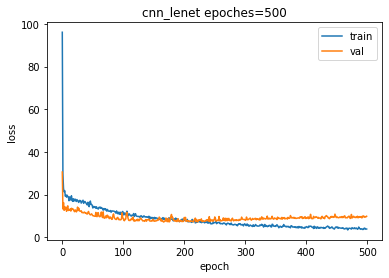

In [20]:
plt.plot(history_lenet.history['loss'])
plt.plot(history_lenet.history['val_loss'])
plt.title('cnn_lenet epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [18]:
eval_cnn_lenet = model_cnn_lenet.evaluate(X_test, y_test)
results = {'cnn_lenet' : eval_cnn_lenet}

12/12 [==============================] - 0s 3ms/step - loss: 9.0261 - mean_squared_error: 9.0261


#### mlp4 model, epoch = 500

In [19]:
model_mlp4 = mlp4(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_mlp4.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_mlp4 = model_mlp4.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4800)              0         
                                                                 
 dense_3 (Dense)             (None, 500)               2400500   
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0   

Epoch 40/500
10/10 [==============================] - 0s 16ms/step - loss: 10.8296 - mean_squared_error: 10.8296 - val_loss: 11.9881 - val_mean_squared_error: 11.9881
Epoch 41/500
10/10 [==============================] - 0s 15ms/step - loss: 10.5042 - mean_squared_error: 10.5042 - val_loss: 8.8388 - val_mean_squared_error: 8.8388
Epoch 42/500
10/10 [==============================] - 0s 16ms/step - loss: 10.5775 - mean_squared_error: 10.5775 - val_loss: 10.0098 - val_mean_squared_error: 10.0098
Epoch 43/500
10/10 [==============================] - 0s 15ms/step - loss: 9.5319 - mean_squared_error: 9.5319 - val_loss: 9.4587 - val_mean_squared_error: 9.4587
Epoch 44/500
10/10 [==============================] - 0s 15ms/step - loss: 10.1105 - mean_squared_error: 10.1105 - val_loss: 18.9481 - val_mean_squared_error: 18.9481
Epoch 45/500
10/10 [==============================] - 0s 15ms/step - loss: 11.5350 - mean_squared_error: 11.5350 - val_loss: 15.7197 - val_mean_squared_error: 15.7197
Epoc

Epoch 90/500
10/10 [==============================] - 0s 17ms/step - loss: 9.3804 - mean_squared_error: 9.3804 - val_loss: 9.8887 - val_mean_squared_error: 9.8887
Epoch 91/500
10/10 [==============================] - 0s 18ms/step - loss: 8.4755 - mean_squared_error: 8.4755 - val_loss: 7.2592 - val_mean_squared_error: 7.2592
Epoch 92/500
10/10 [==============================] - 0s 21ms/step - loss: 9.4022 - mean_squared_error: 9.4022 - val_loss: 9.2580 - val_mean_squared_error: 9.2580
Epoch 93/500
10/10 [==============================] - 0s 16ms/step - loss: 9.7748 - mean_squared_error: 9.7748 - val_loss: 22.3309 - val_mean_squared_error: 22.3309
Epoch 94/500
10/10 [==============================] - 0s 18ms/step - loss: 9.6054 - mean_squared_error: 9.6054 - val_loss: 11.4636 - val_mean_squared_error: 11.4636
Epoch 95/500
10/10 [==============================] - 0s 16ms/step - loss: 9.2908 - mean_squared_error: 9.2908 - val_loss: 7.7534 - val_mean_squared_error: 7.7534
Epoch 96/500
10/10

10/10 [==============================] - 0s 19ms/step - loss: 8.4279 - mean_squared_error: 8.4279 - val_loss: 11.4508 - val_mean_squared_error: 11.4508
Epoch 189/500
10/10 [==============================] - 0s 18ms/step - loss: 8.0622 - mean_squared_error: 8.0622 - val_loss: 13.2965 - val_mean_squared_error: 13.2965
Epoch 190/500
10/10 [==============================] - 0s 19ms/step - loss: 8.9737 - mean_squared_error: 8.9737 - val_loss: 8.5475 - val_mean_squared_error: 8.5475
Epoch 191/500
10/10 [==============================] - 0s 23ms/step - loss: 8.8705 - mean_squared_error: 8.8705 - val_loss: 10.8240 - val_mean_squared_error: 10.8240
Epoch 192/500
10/10 [==============================] - 0s 20ms/step - loss: 8.1155 - mean_squared_error: 8.1155 - val_loss: 7.9863 - val_mean_squared_error: 7.9863
Epoch 193/500
10/10 [==============================] - 0s 21ms/step - loss: 8.1226 - mean_squared_error: 8.1226 - val_loss: 9.4055 - val_mean_squared_error: 9.4055
Epoch 194/500
10/10 [===

Epoch 238/500
10/10 [==============================] - 0s 15ms/step - loss: 7.8913 - mean_squared_error: 7.8913 - val_loss: 7.7960 - val_mean_squared_error: 7.7960
Epoch 239/500
10/10 [==============================] - 0s 15ms/step - loss: 7.7771 - mean_squared_error: 7.7771 - val_loss: 11.3821 - val_mean_squared_error: 11.3821
Epoch 240/500
10/10 [==============================] - 0s 16ms/step - loss: 8.7274 - mean_squared_error: 8.7274 - val_loss: 9.8327 - val_mean_squared_error: 9.8327
Epoch 241/500
10/10 [==============================] - 0s 18ms/step - loss: 7.9196 - mean_squared_error: 7.9196 - val_loss: 9.9994 - val_mean_squared_error: 9.9994
Epoch 242/500
10/10 [==============================] - 0s 16ms/step - loss: 8.0795 - mean_squared_error: 8.0795 - val_loss: 10.0067 - val_mean_squared_error: 10.0067
Epoch 243/500
10/10 [==============================] - 0s 20ms/step - loss: 8.9658 - mean_squared_error: 8.9658 - val_loss: 10.5379 - val_mean_squared_error: 10.5379
Epoch 244/

Epoch 288/500
10/10 [==============================] - 0s 16ms/step - loss: 7.4975 - mean_squared_error: 7.4975 - val_loss: 11.8932 - val_mean_squared_error: 11.8932
Epoch 289/500
10/10 [==============================] - 0s 16ms/step - loss: 8.0954 - mean_squared_error: 8.0954 - val_loss: 9.3744 - val_mean_squared_error: 9.3744
Epoch 290/500
10/10 [==============================] - 0s 16ms/step - loss: 8.0172 - mean_squared_error: 8.0172 - val_loss: 11.0639 - val_mean_squared_error: 11.0639
Epoch 291/500
10/10 [==============================] - 0s 16ms/step - loss: 7.7889 - mean_squared_error: 7.7889 - val_loss: 9.1450 - val_mean_squared_error: 9.1450
Epoch 292/500
10/10 [==============================] - 0s 16ms/step - loss: 7.5885 - mean_squared_error: 7.5885 - val_loss: 8.2525 - val_mean_squared_error: 8.2525
Epoch 293/500
10/10 [==============================] - 0s 16ms/step - loss: 8.2617 - mean_squared_error: 8.2617 - val_loss: 8.5742 - val_mean_squared_error: 8.5742
Epoch 294/50

Epoch 338/500
10/10 [==============================] - 0s 18ms/step - loss: 8.3566 - mean_squared_error: 8.3566 - val_loss: 10.2628 - val_mean_squared_error: 10.2628
Epoch 339/500
10/10 [==============================] - 0s 18ms/step - loss: 8.9683 - mean_squared_error: 8.9683 - val_loss: 14.4807 - val_mean_squared_error: 14.4807
Epoch 340/500
10/10 [==============================] - 0s 20ms/step - loss: 8.8956 - mean_squared_error: 8.8956 - val_loss: 8.3647 - val_mean_squared_error: 8.3647
Epoch 341/500
10/10 [==============================] - 0s 19ms/step - loss: 8.2066 - mean_squared_error: 8.2066 - val_loss: 9.0356 - val_mean_squared_error: 9.0356
Epoch 342/500
10/10 [==============================] - 0s 17ms/step - loss: 8.2367 - mean_squared_error: 8.2367 - val_loss: 11.7250 - val_mean_squared_error: 11.7250
Epoch 343/500
10/10 [==============================] - 0s 17ms/step - loss: 8.3085 - mean_squared_error: 8.3085 - val_loss: 9.9860 - val_mean_squared_error: 9.9860
Epoch 344/

Epoch 437/500
10/10 [==============================] - 0s 17ms/step - loss: 8.0617 - mean_squared_error: 8.0617 - val_loss: 12.1394 - val_mean_squared_error: 12.1394
Epoch 438/500
10/10 [==============================] - 0s 20ms/step - loss: 8.2996 - mean_squared_error: 8.2996 - val_loss: 11.3996 - val_mean_squared_error: 11.3996
Epoch 439/500
10/10 [==============================] - 0s 19ms/step - loss: 8.0201 - mean_squared_error: 8.0201 - val_loss: 10.7805 - val_mean_squared_error: 10.7805
Epoch 440/500
10/10 [==============================] - 0s 16ms/step - loss: 7.9749 - mean_squared_error: 7.9749 - val_loss: 10.2044 - val_mean_squared_error: 10.2044
Epoch 441/500
10/10 [==============================] - 0s 17ms/step - loss: 7.8498 - mean_squared_error: 7.8498 - val_loss: 11.2878 - val_mean_squared_error: 11.2878
Epoch 442/500
10/10 [==============================] - 0s 16ms/step - loss: 8.4045 - mean_squared_error: 8.4045 - val_loss: 10.3486 - val_mean_squared_error: 10.3486
Epoc

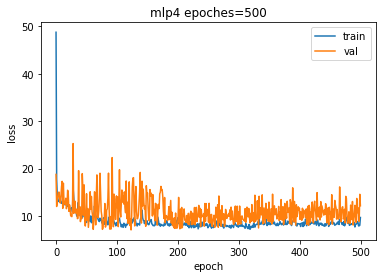

In [20]:
plt.plot(history_mlp4.history['loss'])
plt.plot(history_mlp4.history['val_loss'])
plt.title('mlp4 epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [21]:
eval_mlp4 = model_mlp4.evaluate(X_test, y_test)
results.update({'mlp4' : eval_mlp4})

12/12 [==============================] - 0s 3ms/step - loss: 12.1827 - mean_squared_error: 12.1827


#### cnn_vgg model, epoch=500

In [22]:
model_cnn_vgg = cnn_vgg(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_cnn_vgg.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_vgg = model_cnn_vgg.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

pooling layers: 4
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 64)           9280      
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 128)           24704     
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 128)           49280     
                                         

10/10 [==============================] - 5s 462ms/step - loss: 1.4101 - mean_squared_error: 1.4101 - val_loss: 7.9831 - val_mean_squared_error: 7.9831
Epoch 80/500
10/10 [==============================] - 5s 464ms/step - loss: 1.0993 - mean_squared_error: 1.0993 - val_loss: 8.1511 - val_mean_squared_error: 8.1511
Epoch 81/500
10/10 [==============================] - 5s 503ms/step - loss: 1.1648 - mean_squared_error: 1.1648 - val_loss: 8.1371 - val_mean_squared_error: 8.1371
Epoch 82/500
10/10 [==============================] - 5s 501ms/step - loss: 1.2255 - mean_squared_error: 1.2255 - val_loss: 8.3064 - val_mean_squared_error: 8.3064
Epoch 83/500
10/10 [==============================] - 5s 468ms/step - loss: 1.5033 - mean_squared_error: 1.5033 - val_loss: 9.0370 - val_mean_squared_error: 9.0370
Epoch 84/500
10/10 [==============================] - 5s 460ms/step - loss: 1.6912 - mean_squared_error: 1.6912 - val_loss: 7.5823 - val_mean_squared_error: 7.5823
Epoch 85/500
10/10 [=========

Epoch 129/500
10/10 [==============================] - 5s 459ms/step - loss: 1.1642 - mean_squared_error: 1.1642 - val_loss: 7.6405 - val_mean_squared_error: 7.6405
Epoch 130/500
10/10 [==============================] - 5s 458ms/step - loss: 1.2458 - mean_squared_error: 1.2458 - val_loss: 7.8975 - val_mean_squared_error: 7.8975
Epoch 131/500
10/10 [==============================] - 5s 455ms/step - loss: 1.4705 - mean_squared_error: 1.4705 - val_loss: 8.2692 - val_mean_squared_error: 8.2692
Epoch 132/500
10/10 [==============================] - 5s 455ms/step - loss: 0.9035 - mean_squared_error: 0.9035 - val_loss: 7.4130 - val_mean_squared_error: 7.4130
Epoch 133/500
10/10 [==============================] - 5s 459ms/step - loss: 0.7781 - mean_squared_error: 0.7781 - val_loss: 7.7270 - val_mean_squared_error: 7.7270
Epoch 134/500
10/10 [==============================] - 5s 459ms/step - loss: 0.8267 - mean_squared_error: 0.8267 - val_loss: 7.3301 - val_mean_squared_error: 7.3301
Epoch 135/

Epoch 179/500
10/10 [==============================] - 5s 454ms/step - loss: 0.7213 - mean_squared_error: 0.7213 - val_loss: 7.5895 - val_mean_squared_error: 7.5895
Epoch 180/500
10/10 [==============================] - 5s 461ms/step - loss: 0.6510 - mean_squared_error: 0.6510 - val_loss: 7.3488 - val_mean_squared_error: 7.3488
Epoch 181/500
10/10 [==============================] - 5s 458ms/step - loss: 0.5801 - mean_squared_error: 0.5801 - val_loss: 7.0983 - val_mean_squared_error: 7.0983
Epoch 182/500
10/10 [==============================] - 5s 459ms/step - loss: 0.6109 - mean_squared_error: 0.6109 - val_loss: 7.2974 - val_mean_squared_error: 7.2974
Epoch 183/500
10/10 [==============================] - 5s 457ms/step - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 7.3326 - val_mean_squared_error: 7.3326
Epoch 184/500
10/10 [==============================] - 5s 458ms/step - loss: 0.6847 - mean_squared_error: 0.6847 - val_loss: 7.1404 - val_mean_squared_error: 7.1404
Epoch 185/

Epoch 229/500
10/10 [==============================] - 5s 461ms/step - loss: 0.7249 - mean_squared_error: 0.7249 - val_loss: 7.6665 - val_mean_squared_error: 7.6665
Epoch 230/500
10/10 [==============================] - 5s 460ms/step - loss: 0.7227 - mean_squared_error: 0.7227 - val_loss: 6.8545 - val_mean_squared_error: 6.8545
Epoch 231/500
10/10 [==============================] - 5s 457ms/step - loss: 0.7337 - mean_squared_error: 0.7337 - val_loss: 7.2904 - val_mean_squared_error: 7.2904
Epoch 232/500
10/10 [==============================] - 5s 460ms/step - loss: 0.5998 - mean_squared_error: 0.5998 - val_loss: 6.8180 - val_mean_squared_error: 6.8180
Epoch 233/500
10/10 [==============================] - 5s 460ms/step - loss: 0.6688 - mean_squared_error: 0.6688 - val_loss: 6.9090 - val_mean_squared_error: 6.9090
Epoch 234/500
10/10 [==============================] - 5s 459ms/step - loss: 0.6591 - mean_squared_error: 0.6591 - val_loss: 7.1508 - val_mean_squared_error: 7.1508
Epoch 235/

Epoch 279/500
10/10 [==============================] - 5s 502ms/step - loss: 0.6143 - mean_squared_error: 0.6143 - val_loss: 7.2654 - val_mean_squared_error: 7.2654
Epoch 280/500
10/10 [==============================] - 5s 479ms/step - loss: 0.6472 - mean_squared_error: 0.6472 - val_loss: 6.9304 - val_mean_squared_error: 6.9304
Epoch 281/500
10/10 [==============================] - 5s 465ms/step - loss: 0.5934 - mean_squared_error: 0.5934 - val_loss: 7.0432 - val_mean_squared_error: 7.0432
Epoch 282/500
10/10 [==============================] - 5s 515ms/step - loss: 0.5399 - mean_squared_error: 0.5399 - val_loss: 6.9853 - val_mean_squared_error: 6.9853
Epoch 283/500
10/10 [==============================] - 6s 558ms/step - loss: 0.5774 - mean_squared_error: 0.5774 - val_loss: 7.0672 - val_mean_squared_error: 7.0672
Epoch 284/500
10/10 [==============================] - 5s 494ms/step - loss: 0.5308 - mean_squared_error: 0.5308 - val_loss: 7.2544 - val_mean_squared_error: 7.2544
Epoch 285/

Epoch 329/500
10/10 [==============================] - 4s 439ms/step - loss: 0.6709 - mean_squared_error: 0.6709 - val_loss: 7.1096 - val_mean_squared_error: 7.1096
Epoch 330/500
10/10 [==============================] - 4s 442ms/step - loss: 0.5913 - mean_squared_error: 0.5913 - val_loss: 7.1895 - val_mean_squared_error: 7.1895
Epoch 331/500
10/10 [==============================] - 4s 443ms/step - loss: 0.5907 - mean_squared_error: 0.5907 - val_loss: 7.1557 - val_mean_squared_error: 7.1557
Epoch 332/500
10/10 [==============================] - 4s 439ms/step - loss: 0.6019 - mean_squared_error: 0.6019 - val_loss: 7.4744 - val_mean_squared_error: 7.4744
Epoch 333/500
10/10 [==============================] - 4s 444ms/step - loss: 0.6574 - mean_squared_error: 0.6574 - val_loss: 6.8311 - val_mean_squared_error: 6.8311
Epoch 334/500
10/10 [==============================] - 4s 439ms/step - loss: 0.6098 - mean_squared_error: 0.6098 - val_loss: 7.1253 - val_mean_squared_error: 7.1253
Epoch 335/

Epoch 379/500
10/10 [==============================] - 5s 450ms/step - loss: 0.5547 - mean_squared_error: 0.5547 - val_loss: 7.1746 - val_mean_squared_error: 7.1746
Epoch 380/500
10/10 [==============================] - 4s 447ms/step - loss: 0.6527 - mean_squared_error: 0.6527 - val_loss: 6.8557 - val_mean_squared_error: 6.8557
Epoch 381/500
10/10 [==============================] - 4s 448ms/step - loss: 0.6428 - mean_squared_error: 0.6428 - val_loss: 6.9156 - val_mean_squared_error: 6.9156
Epoch 382/500
10/10 [==============================] - 4s 448ms/step - loss: 0.6487 - mean_squared_error: 0.6487 - val_loss: 7.0197 - val_mean_squared_error: 7.0197
Epoch 383/500
10/10 [==============================] - 4s 447ms/step - loss: 0.6183 - mean_squared_error: 0.6183 - val_loss: 6.7782 - val_mean_squared_error: 6.7782
Epoch 384/500
10/10 [==============================] - 4s 449ms/step - loss: 0.6076 - mean_squared_error: 0.6076 - val_loss: 7.5393 - val_mean_squared_error: 7.5393
Epoch 385/

Epoch 429/500
10/10 [==============================] - 5s 520ms/step - loss: 0.5437 - mean_squared_error: 0.5437 - val_loss: 7.0621 - val_mean_squared_error: 7.0621
Epoch 430/500
10/10 [==============================] - 5s 482ms/step - loss: 0.6091 - mean_squared_error: 0.6091 - val_loss: 7.2298 - val_mean_squared_error: 7.2298
Epoch 431/500
10/10 [==============================] - 5s 468ms/step - loss: 0.6041 - mean_squared_error: 0.6041 - val_loss: 7.3435 - val_mean_squared_error: 7.3435
Epoch 432/500
10/10 [==============================] - 5s 511ms/step - loss: 0.4858 - mean_squared_error: 0.4858 - val_loss: 6.9373 - val_mean_squared_error: 6.9373
Epoch 433/500
10/10 [==============================] - 6s 541ms/step - loss: 0.5035 - mean_squared_error: 0.5035 - val_loss: 6.9962 - val_mean_squared_error: 6.9962
Epoch 434/500
10/10 [==============================] - 5s 473ms/step - loss: 0.5331 - mean_squared_error: 0.5331 - val_loss: 7.4685 - val_mean_squared_error: 7.4685
Epoch 435/

Epoch 479/500
10/10 [==============================] - 5s 453ms/step - loss: 0.4278 - mean_squared_error: 0.4278 - val_loss: 7.2315 - val_mean_squared_error: 7.2315
Epoch 480/500
10/10 [==============================] - 5s 502ms/step - loss: 0.4126 - mean_squared_error: 0.4126 - val_loss: 7.1081 - val_mean_squared_error: 7.1081
Epoch 481/500
10/10 [==============================] - 5s 496ms/step - loss: 0.4297 - mean_squared_error: 0.4297 - val_loss: 6.9828 - val_mean_squared_error: 6.9828
Epoch 482/500
10/10 [==============================] - 5s 518ms/step - loss: 0.4530 - mean_squared_error: 0.4530 - val_loss: 6.9941 - val_mean_squared_error: 6.9941
Epoch 483/500
10/10 [==============================] - 5s 514ms/step - loss: 0.3804 - mean_squared_error: 0.3804 - val_loss: 6.7386 - val_mean_squared_error: 6.7386
Epoch 484/500
10/10 [==============================] - 5s 506ms/step - loss: 0.3720 - mean_squared_error: 0.3720 - val_loss: 6.6997 - val_mean_squared_error: 6.6997
Epoch 485/

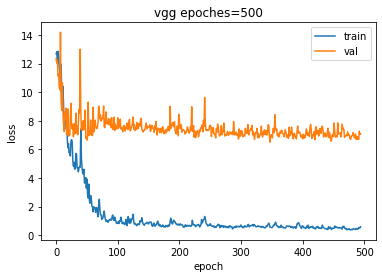

In [23]:
plt.plot(history_vgg.history['loss'][5:])
plt.plot(history_vgg.history['val_loss'][5:])
plt.title('vgg epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [24]:
eval_vgg = model_cnn_vgg.evaluate(X_test, y_test)
results.update({'vgg' : eval_vgg})

12/12 [==============================] - 0s 24ms/step - loss: 6.3355 - mean_squared_error: 6.3355


#### lstm1v0 model, epoch=500

In [25]:
model_lstm1v0 = lstm1v0(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_lstm1v0.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_lstm1v0 = model_lstm1v0.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 lstm (LSTM)                 (None, 100)               59600     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
10/10 [==============================] - 3s 145ms/step - loss: 93.1067 - mean_squared_error: 93.1067 - val_loss: 54.8680 - val_mean_squared_error: 54.8680
Epoch 2/500
10/10 [==============================] - 1s 102ms/step - loss: 33.1749 - mean_squared_error: 33.1749 - val_loss: 17.6533 - val_mean_squared_

10/10 [==============================] - 1s 97ms/step - loss: 12.5558 - mean_squared_error: 12.5558 - val_loss: 12.6323 - val_mean_squared_error: 12.6323
Epoch 46/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5665 - mean_squared_error: 12.5665 - val_loss: 12.5528 - val_mean_squared_error: 12.5528
Epoch 47/500
10/10 [==============================] - 1s 96ms/step - loss: 12.5688 - mean_squared_error: 12.5688 - val_loss: 12.5842 - val_mean_squared_error: 12.5842
Epoch 48/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5377 - mean_squared_error: 12.5377 - val_loss: 12.5343 - val_mean_squared_error: 12.5343
Epoch 49/500
10/10 [==============================] - 1s 96ms/step - loss: 12.6259 - mean_squared_error: 12.6259 - val_loss: 12.5230 - val_mean_squared_error: 12.5230
Epoch 50/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5562 - mean_squared_error: 12.5562 - val_loss: 12.6637 - val_mean_squared_error: 12.6637
Epoch 51/50

Epoch 143/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5894 - mean_squared_error: 12.5894 - val_loss: 12.5152 - val_mean_squared_error: 12.5152
Epoch 144/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5490 - mean_squared_error: 12.5490 - val_loss: 12.6071 - val_mean_squared_error: 12.6071
Epoch 145/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5505 - mean_squared_error: 12.5505 - val_loss: 12.5773 - val_mean_squared_error: 12.5773
Epoch 146/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5427 - mean_squared_error: 12.5427 - val_loss: 12.5198 - val_mean_squared_error: 12.5198
Epoch 147/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5697 - mean_squared_error: 12.5697 - val_loss: 12.5590 - val_mean_squared_error: 12.5590
Epoch 148/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5422 - mean_squared_error: 12.5422 - val_loss: 12.5172 - val_mean_squared_error: 

Epoch 192/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5424 - mean_squared_error: 12.5424 - val_loss: 12.5516 - val_mean_squared_error: 12.5516
Epoch 193/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5495 - mean_squared_error: 12.5495 - val_loss: 12.5806 - val_mean_squared_error: 12.5806
Epoch 194/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5327 - mean_squared_error: 12.5327 - val_loss: 12.5383 - val_mean_squared_error: 12.5383
Epoch 195/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5276 - mean_squared_error: 12.5276 - val_loss: 12.5088 - val_mean_squared_error: 12.5088
Epoch 196/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5279 - mean_squared_error: 12.5279 - val_loss: 12.5820 - val_mean_squared_error: 12.5820
Epoch 197/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5508 - mean_squared_error: 12.5508 - val_loss: 12.5860 - val_mean_squared_error: 

Epoch 241/500
10/10 [==============================] - 1s 96ms/step - loss: 12.5048 - mean_squared_error: 12.5048 - val_loss: 12.5919 - val_mean_squared_error: 12.5919
Epoch 242/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5247 - mean_squared_error: 12.5247 - val_loss: 12.5370 - val_mean_squared_error: 12.5370
Epoch 243/500
10/10 [==============================] - 1s 97ms/step - loss: 12.5142 - mean_squared_error: 12.5142 - val_loss: 12.5234 - val_mean_squared_error: 12.5234
Epoch 244/500
10/10 [==============================] - 1s 103ms/step - loss: 12.5313 - mean_squared_error: 12.5313 - val_loss: 12.5245 - val_mean_squared_error: 12.5245
Epoch 245/500
10/10 [==============================] - 1s 99ms/step - loss: 12.5467 - mean_squared_error: 12.5467 - val_loss: 12.5581 - val_mean_squared_error: 12.5581
Epoch 246/500
10/10 [==============================] - 1s 99ms/step - loss: 12.5409 - mean_squared_error: 12.5409 - val_loss: 12.5072 - val_mean_squared_error:

Epoch 290/500
10/10 [==============================] - 1s 98ms/step - loss: 12.4708 - mean_squared_error: 12.4708 - val_loss: 12.4884 - val_mean_squared_error: 12.4884
Epoch 291/500
10/10 [==============================] - 1s 98ms/step - loss: 12.5086 - mean_squared_error: 12.5086 - val_loss: 12.6227 - val_mean_squared_error: 12.6227
Epoch 292/500
10/10 [==============================] - 1s 98ms/step - loss: 12.4690 - mean_squared_error: 12.4690 - val_loss: 12.4810 - val_mean_squared_error: 12.4810
Epoch 293/500
10/10 [==============================] - 1s 98ms/step - loss: 12.4888 - mean_squared_error: 12.4888 - val_loss: 12.5322 - val_mean_squared_error: 12.5322
Epoch 294/500
10/10 [==============================] - 1s 98ms/step - loss: 12.4905 - mean_squared_error: 12.4905 - val_loss: 12.5303 - val_mean_squared_error: 12.5303
Epoch 295/500
10/10 [==============================] - 1s 98ms/step - loss: 12.4868 - mean_squared_error: 12.4868 - val_loss: 12.5023 - val_mean_squared_error: 

Epoch 339/500
10/10 [==============================] - 1s 98ms/step - loss: 11.3563 - mean_squared_error: 11.3563 - val_loss: 11.4948 - val_mean_squared_error: 11.4948
Epoch 340/500
10/10 [==============================] - 1s 97ms/step - loss: 11.2126 - mean_squared_error: 11.2126 - val_loss: 11.4378 - val_mean_squared_error: 11.4378
Epoch 341/500
10/10 [==============================] - 1s 98ms/step - loss: 10.9698 - mean_squared_error: 10.9698 - val_loss: 11.3944 - val_mean_squared_error: 11.3944
Epoch 342/500
10/10 [==============================] - 1s 98ms/step - loss: 10.8028 - mean_squared_error: 10.8028 - val_loss: 11.4746 - val_mean_squared_error: 11.4746
Epoch 343/500
10/10 [==============================] - 1s 98ms/step - loss: 10.8041 - mean_squared_error: 10.8041 - val_loss: 11.8634 - val_mean_squared_error: 11.8634
Epoch 344/500
10/10 [==============================] - 1s 98ms/step - loss: 10.9954 - mean_squared_error: 10.9954 - val_loss: 11.7404 - val_mean_squared_error: 

Epoch 388/500
10/10 [==============================] - 1s 97ms/step - loss: 9.2391 - mean_squared_error: 9.2391 - val_loss: 10.7975 - val_mean_squared_error: 10.7975
Epoch 389/500
10/10 [==============================] - 1s 97ms/step - loss: 9.5284 - mean_squared_error: 9.5284 - val_loss: 10.3170 - val_mean_squared_error: 10.3170
Epoch 390/500
10/10 [==============================] - 1s 98ms/step - loss: 9.1820 - mean_squared_error: 9.1820 - val_loss: 10.3035 - val_mean_squared_error: 10.3035
Epoch 391/500
10/10 [==============================] - 1s 98ms/step - loss: 9.4017 - mean_squared_error: 9.4017 - val_loss: 10.5727 - val_mean_squared_error: 10.5727
Epoch 392/500
10/10 [==============================] - 1s 97ms/step - loss: 9.1576 - mean_squared_error: 9.1576 - val_loss: 10.1169 - val_mean_squared_error: 10.1169
Epoch 393/500
10/10 [==============================] - 1s 98ms/step - loss: 9.0652 - mean_squared_error: 9.0652 - val_loss: 10.5729 - val_mean_squared_error: 10.5729
Epoc

Epoch 438/500
10/10 [==============================] - 1s 100ms/step - loss: 6.5655 - mean_squared_error: 6.5655 - val_loss: 9.1726 - val_mean_squared_error: 9.1726
Epoch 439/500
10/10 [==============================] - 1s 98ms/step - loss: 6.5815 - mean_squared_error: 6.5815 - val_loss: 7.6008 - val_mean_squared_error: 7.6008
Epoch 440/500
10/10 [==============================] - 1s 99ms/step - loss: 6.3382 - mean_squared_error: 6.3382 - val_loss: 7.4621 - val_mean_squared_error: 7.4621
Epoch 441/500
10/10 [==============================] - 1s 98ms/step - loss: 6.6531 - mean_squared_error: 6.6531 - val_loss: 7.5566 - val_mean_squared_error: 7.5566
Epoch 442/500
10/10 [==============================] - 1s 99ms/step - loss: 6.3194 - mean_squared_error: 6.3194 - val_loss: 7.6713 - val_mean_squared_error: 7.6713
Epoch 443/500
10/10 [==============================] - 1s 99ms/step - loss: 6.9185 - mean_squared_error: 6.9185 - val_loss: 8.5126 - val_mean_squared_error: 8.5126
Epoch 444/500
1

Epoch 488/500
10/10 [==============================] - 1s 98ms/step - loss: 5.5289 - mean_squared_error: 5.5289 - val_loss: 7.1059 - val_mean_squared_error: 7.1059
Epoch 489/500
10/10 [==============================] - 1s 98ms/step - loss: 5.4036 - mean_squared_error: 5.4036 - val_loss: 7.1590 - val_mean_squared_error: 7.1590
Epoch 490/500
10/10 [==============================] - 1s 98ms/step - loss: 5.3563 - mean_squared_error: 5.3563 - val_loss: 7.5847 - val_mean_squared_error: 7.5847
Epoch 491/500
10/10 [==============================] - 1s 100ms/step - loss: 5.4820 - mean_squared_error: 5.4820 - val_loss: 7.0750 - val_mean_squared_error: 7.0750
Epoch 492/500
10/10 [==============================] - 1s 99ms/step - loss: 5.3804 - mean_squared_error: 5.3804 - val_loss: 7.1445 - val_mean_squared_error: 7.1445
Epoch 493/500
10/10 [==============================] - 1s 100ms/step - loss: 5.5947 - mean_squared_error: 5.5947 - val_loss: 7.6828 - val_mean_squared_error: 7.6828
Epoch 494/500


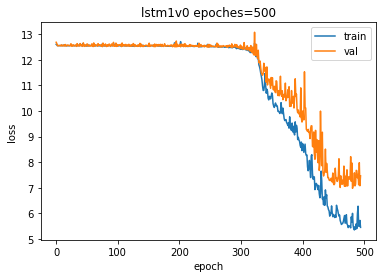

In [26]:
plt.plot(history_lstm1v0.history['loss'][5:])
plt.plot(history_lstm1v0.history['val_loss'][5:])
plt.title('lstm1v0 epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [27]:
eval_lstm1v0 = model_lstm1v0.evaluate(X_test, y_test)
results.update({'lstm1v0': eval_lstm1v0})

12/12 [==============================] - 0s 11ms/step - loss: 6.4879 - mean_squared_error: 6.4879


#### lstm1v0 model, epoch=1000

In [44]:
model_lstm1v0_1000 = lstm1v0(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_lstm1v0_1000.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_lstm1v0_1000 = model_lstm1v0_1000.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               59600     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 145ms/step - loss: 92.3612 - mean_squared_error: 92.3612 - val_loss: 52.0973 - val_mean_squared_error: 52.0973
Epoch 2/1000
10/10 [==============================] - 1s 107ms/step - loss: 31.3529 - mean_squared_error: 31.3529 - val_loss: 17.0051 - val_mean_square

Epoch 45/1000
10/10 [==============================] - 1s 114ms/step - loss: 12.5715 - mean_squared_error: 12.5715 - val_loss: 12.5747 - val_mean_squared_error: 12.5747
Epoch 46/1000
10/10 [==============================] - 1s 106ms/step - loss: 12.5643 - mean_squared_error: 12.5643 - val_loss: 12.5157 - val_mean_squared_error: 12.5157
Epoch 47/1000
10/10 [==============================] - 1s 106ms/step - loss: 12.5627 - mean_squared_error: 12.5627 - val_loss: 12.6061 - val_mean_squared_error: 12.6061
Epoch 48/1000
10/10 [==============================] - 1s 111ms/step - loss: 12.5509 - mean_squared_error: 12.5509 - val_loss: 12.5243 - val_mean_squared_error: 12.5243
Epoch 49/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5526 - mean_squared_error: 12.5526 - val_loss: 12.5735 - val_mean_squared_error: 12.5735
Epoch 50/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5543 - mean_squared_error: 12.5543 - val_loss: 12.5865 - val_mean_squared_e

10/10 [==============================] - 1s 100ms/step - loss: 12.5664 - mean_squared_error: 12.5664 - val_loss: 12.5276 - val_mean_squared_error: 12.5276
Epoch 142/1000
10/10 [==============================] - 1s 100ms/step - loss: 12.5447 - mean_squared_error: 12.5447 - val_loss: 12.6170 - val_mean_squared_error: 12.6170
Epoch 143/1000
10/10 [==============================] - 1s 99ms/step - loss: 12.5476 - mean_squared_error: 12.5476 - val_loss: 12.5572 - val_mean_squared_error: 12.5572
Epoch 144/1000
10/10 [==============================] - 1s 100ms/step - loss: 12.5479 - mean_squared_error: 12.5479 - val_loss: 12.5510 - val_mean_squared_error: 12.5510
Epoch 145/1000
10/10 [==============================] - 1s 99ms/step - loss: 12.5352 - mean_squared_error: 12.5352 - val_loss: 12.5165 - val_mean_squared_error: 12.5165
Epoch 146/1000
10/10 [==============================] - 1s 100ms/step - loss: 12.5495 - mean_squared_error: 12.5495 - val_loss: 12.5715 - val_mean_squared_error: 12.57

10/10 [==============================] - 1s 99ms/step - loss: 12.5548 - mean_squared_error: 12.5548 - val_loss: 12.5182 - val_mean_squared_error: 12.5182
Epoch 238/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.4982 - mean_squared_error: 12.4982 - val_loss: 12.5308 - val_mean_squared_error: 12.5308
Epoch 239/1000
10/10 [==============================] - 1s 104ms/step - loss: 12.4915 - mean_squared_error: 12.4915 - val_loss: 12.5418 - val_mean_squared_error: 12.5418
Epoch 240/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.4985 - mean_squared_error: 12.4985 - val_loss: 12.4956 - val_mean_squared_error: 12.4956
Epoch 241/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5499 - mean_squared_error: 12.5499 - val_loss: 12.5341 - val_mean_squared_error: 12.5341
Epoch 242/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.4947 - mean_squared_error: 12.4947 - val_loss: 12.5226 - val_mean_squared_error: 12.5

10/10 [==============================] - 1s 102ms/step - loss: 12.4681 - mean_squared_error: 12.4681 - val_loss: 12.3479 - val_mean_squared_error: 12.3479
Epoch 334/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.3068 - mean_squared_error: 12.3068 - val_loss: 12.8223 - val_mean_squared_error: 12.8223
Epoch 335/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.3973 - mean_squared_error: 12.3973 - val_loss: 12.5267 - val_mean_squared_error: 12.5267
Epoch 336/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.3082 - mean_squared_error: 12.3082 - val_loss: 12.7819 - val_mean_squared_error: 12.7819
Epoch 337/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.2832 - mean_squared_error: 12.2832 - val_loss: 12.3510 - val_mean_squared_error: 12.3510
Epoch 338/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.2835 - mean_squared_error: 12.2835 - val_loss: 12.3472 - val_mean_squared_error: 12.

10/10 [==============================] - 1s 104ms/step - loss: 6.8492 - mean_squared_error: 6.8492 - val_loss: 8.2391 - val_mean_squared_error: 8.2391
Epoch 431/1000
10/10 [==============================] - 1s 103ms/step - loss: 6.9628 - mean_squared_error: 6.9628 - val_loss: 8.6284 - val_mean_squared_error: 8.6284
Epoch 432/1000
10/10 [==============================] - 1s 103ms/step - loss: 7.2024 - mean_squared_error: 7.2024 - val_loss: 8.5616 - val_mean_squared_error: 8.5616
Epoch 433/1000
10/10 [==============================] - 1s 102ms/step - loss: 7.7913 - mean_squared_error: 7.7913 - val_loss: 7.7287 - val_mean_squared_error: 7.7287
Epoch 434/1000
10/10 [==============================] - 1s 104ms/step - loss: 7.0221 - mean_squared_error: 7.0221 - val_loss: 9.1667 - val_mean_squared_error: 9.1667
Epoch 435/1000
10/10 [==============================] - 1s 104ms/step - loss: 7.4067 - mean_squared_error: 7.4067 - val_loss: 7.5043 - val_mean_squared_error: 7.5043
Epoch 436/1000
10/1

10/10 [==============================] - 1s 104ms/step - loss: 5.4072 - mean_squared_error: 5.4072 - val_loss: 6.9269 - val_mean_squared_error: 6.9269
Epoch 529/1000
10/10 [==============================] - 1s 102ms/step - loss: 5.5721 - mean_squared_error: 5.5721 - val_loss: 8.0235 - val_mean_squared_error: 8.0235
Epoch 530/1000
10/10 [==============================] - 1s 101ms/step - loss: 5.7229 - mean_squared_error: 5.7229 - val_loss: 7.6560 - val_mean_squared_error: 7.6560
Epoch 531/1000
10/10 [==============================] - 1s 105ms/step - loss: 5.5930 - mean_squared_error: 5.5930 - val_loss: 7.6125 - val_mean_squared_error: 7.6125
Epoch 532/1000
10/10 [==============================] - 1s 103ms/step - loss: 5.6452 - mean_squared_error: 5.6452 - val_loss: 6.8339 - val_mean_squared_error: 6.8339
Epoch 533/1000
10/10 [==============================] - 1s 103ms/step - loss: 5.3176 - mean_squared_error: 5.3176 - val_loss: 6.7017 - val_mean_squared_error: 6.7017
Epoch 534/1000
10/1

10/10 [==============================] - 1s 104ms/step - loss: 4.7246 - mean_squared_error: 4.7246 - val_loss: 6.9662 - val_mean_squared_error: 6.9662
Epoch 627/1000
10/10 [==============================] - 1s 102ms/step - loss: 5.0808 - mean_squared_error: 5.0808 - val_loss: 6.9471 - val_mean_squared_error: 6.9471
Epoch 628/1000
10/10 [==============================] - 1s 102ms/step - loss: 4.9340 - mean_squared_error: 4.9340 - val_loss: 6.9966 - val_mean_squared_error: 6.9966
Epoch 629/1000
10/10 [==============================] - 1s 102ms/step - loss: 4.7188 - mean_squared_error: 4.7188 - val_loss: 6.7715 - val_mean_squared_error: 6.7715
Epoch 630/1000
10/10 [==============================] - 1s 104ms/step - loss: 4.8586 - mean_squared_error: 4.8586 - val_loss: 7.5735 - val_mean_squared_error: 7.5735
Epoch 631/1000
10/10 [==============================] - 1s 103ms/step - loss: 5.1508 - mean_squared_error: 5.1508 - val_loss: 7.4794 - val_mean_squared_error: 7.4794
Epoch 632/1000
10/1

10/10 [==============================] - 1s 104ms/step - loss: 4.4637 - mean_squared_error: 4.4637 - val_loss: 6.7852 - val_mean_squared_error: 6.7852
Epoch 725/1000
10/10 [==============================] - 1s 104ms/step - loss: 4.9781 - mean_squared_error: 4.9781 - val_loss: 7.5705 - val_mean_squared_error: 7.5705
Epoch 726/1000
10/10 [==============================] - 1s 100ms/step - loss: 4.7914 - mean_squared_error: 4.7914 - val_loss: 7.3143 - val_mean_squared_error: 7.3143
Epoch 727/1000
10/10 [==============================] - 1s 103ms/step - loss: 4.7013 - mean_squared_error: 4.7013 - val_loss: 6.8244 - val_mean_squared_error: 6.8244
Epoch 728/1000
10/10 [==============================] - 1s 103ms/step - loss: 4.4988 - mean_squared_error: 4.4988 - val_loss: 6.8448 - val_mean_squared_error: 6.8448
Epoch 729/1000
10/10 [==============================] - 1s 103ms/step - loss: 4.3591 - mean_squared_error: 4.3591 - val_loss: 6.6866 - val_mean_squared_error: 6.6866
Epoch 730/1000
10/1

10/10 [==============================] - 1s 102ms/step - loss: 3.7839 - mean_squared_error: 3.7839 - val_loss: 6.8112 - val_mean_squared_error: 6.8112
Epoch 823/1000
10/10 [==============================] - 1s 101ms/step - loss: 4.0141 - mean_squared_error: 4.0141 - val_loss: 7.3011 - val_mean_squared_error: 7.3011
Epoch 824/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.8529 - mean_squared_error: 3.8529 - val_loss: 6.9249 - val_mean_squared_error: 6.9249
Epoch 825/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.7903 - mean_squared_error: 3.7903 - val_loss: 6.8647 - val_mean_squared_error: 6.8647
Epoch 826/1000
10/10 [==============================] - 1s 103ms/step - loss: 3.6913 - mean_squared_error: 3.6913 - val_loss: 6.8276 - val_mean_squared_error: 6.8276
Epoch 827/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.6546 - mean_squared_error: 3.6546 - val_loss: 6.7559 - val_mean_squared_error: 6.7559
Epoch 828/1000
10/1

10/10 [==============================] - 1s 102ms/step - loss: 3.2119 - mean_squared_error: 3.2119 - val_loss: 7.3648 - val_mean_squared_error: 7.3648
Epoch 921/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.1068 - mean_squared_error: 3.1068 - val_loss: 6.9652 - val_mean_squared_error: 6.9652
Epoch 922/1000
10/10 [==============================] - 1s 103ms/step - loss: 3.3822 - mean_squared_error: 3.3822 - val_loss: 8.7282 - val_mean_squared_error: 8.7282
Epoch 923/1000
10/10 [==============================] - 1s 104ms/step - loss: 3.8353 - mean_squared_error: 3.8353 - val_loss: 6.8021 - val_mean_squared_error: 6.8021
Epoch 924/1000
10/10 [==============================] - 1s 103ms/step - loss: 3.1861 - mean_squared_error: 3.1861 - val_loss: 7.4086 - val_mean_squared_error: 7.4086
Epoch 925/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.1550 - mean_squared_error: 3.1550 - val_loss: 7.5437 - val_mean_squared_error: 7.5437
Epoch 926/1000
10/1

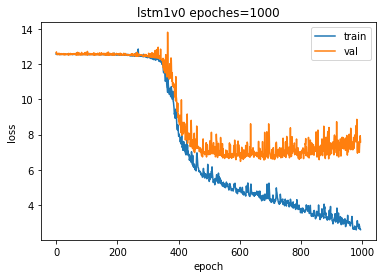

In [47]:
plt.plot(history_lstm1v0_1000.history['loss'][5:])
plt.plot(history_lstm1v0_1000.history['val_loss'][5:])
plt.title('lstm1v0 epoches=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [48]:
eval_lstm1v0_1000 = model_lstm1v0_1000.evaluate(X_test, y_test)
results.update({'lstm1v0——epoch=1000': eval_lstm1v0_1000})

12/12 [==============================] - 0s 12ms/step - loss: 6.5001 - mean_squared_error: 6.5001


#### lstm1 model, epoch=1000

In [49]:
model_lstm1 = lstm1(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_lstm1.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_lstm1 = model_lstm1.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               59600     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 3s 143ms/step - loss: 104.2858 - mean_squared_error: 104.2858 - val_loss: 66.5418 - val_mean_squared_error: 66.5418
Epoch 2/1000
10/10 [==============================] - 1s 106ms/step - loss: 40.1239 - mean_squared_error: 40.1239 - val_loss: 20.4463 - val_mean_squa

Epoch 45/1000
10/10 [==============================] - 1s 104ms/step - loss: 12.5507 - mean_squared_error: 12.5507 - val_loss: 12.5509 - val_mean_squared_error: 12.5509
Epoch 46/1000
10/10 [==============================] - 1s 106ms/step - loss: 12.5498 - mean_squared_error: 12.5498 - val_loss: 12.5521 - val_mean_squared_error: 12.5521
Epoch 47/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5453 - mean_squared_error: 12.5453 - val_loss: 12.5683 - val_mean_squared_error: 12.5683
Epoch 48/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.6055 - mean_squared_error: 12.6055 - val_loss: 12.6042 - val_mean_squared_error: 12.6042
Epoch 49/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5989 - mean_squared_error: 12.5989 - val_loss: 12.5175 - val_mean_squared_error: 12.5175
Epoch 50/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.5524 - mean_squared_error: 12.5524 - val_loss: 12.6210 - val_mean_squared_e

10/10 [==============================] - 1s 102ms/step - loss: 12.5741 - mean_squared_error: 12.5741 - val_loss: 12.5154 - val_mean_squared_error: 12.5154
Epoch 142/1000
10/10 [==============================] - 1s 104ms/step - loss: 12.5792 - mean_squared_error: 12.5792 - val_loss: 12.5840 - val_mean_squared_error: 12.5840
Epoch 143/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5862 - mean_squared_error: 12.5862 - val_loss: 12.6140 - val_mean_squared_error: 12.6140
Epoch 144/1000
10/10 [==============================] - 1s 104ms/step - loss: 12.5703 - mean_squared_error: 12.5703 - val_loss: 12.5142 - val_mean_squared_error: 12.5142
Epoch 145/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.5355 - mean_squared_error: 12.5355 - val_loss: 12.6023 - val_mean_squared_error: 12.6023
Epoch 146/1000
10/10 [==============================] - 1s 104ms/step - loss: 12.5880 - mean_squared_error: 12.5880 - val_loss: 12.5991 - val_mean_squared_error: 12.

10/10 [==============================] - 1s 105ms/step - loss: 12.5337 - mean_squared_error: 12.5337 - val_loss: 12.5306 - val_mean_squared_error: 12.5306
Epoch 238/1000
10/10 [==============================] - 1s 103ms/step - loss: 12.5747 - mean_squared_error: 12.5747 - val_loss: 12.5261 - val_mean_squared_error: 12.5261
Epoch 239/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.5375 - mean_squared_error: 12.5375 - val_loss: 12.5851 - val_mean_squared_error: 12.5851
Epoch 240/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.5366 - mean_squared_error: 12.5366 - val_loss: 12.5289 - val_mean_squared_error: 12.5289
Epoch 241/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.5397 - mean_squared_error: 12.5397 - val_loss: 12.5528 - val_mean_squared_error: 12.5528
Epoch 242/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.5290 - mean_squared_error: 12.5290 - val_loss: 12.5487 - val_mean_squared_error: 12.

10/10 [==============================] - 1s 101ms/step - loss: 12.5297 - mean_squared_error: 12.5297 - val_loss: 12.5126 - val_mean_squared_error: 12.5126
Epoch 334/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.4971 - mean_squared_error: 12.4971 - val_loss: 12.5317 - val_mean_squared_error: 12.5317
Epoch 335/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.4967 - mean_squared_error: 12.4967 - val_loss: 12.5721 - val_mean_squared_error: 12.5721
Epoch 336/1000
10/10 [==============================] - 1s 102ms/step - loss: 12.4996 - mean_squared_error: 12.4996 - val_loss: 12.5148 - val_mean_squared_error: 12.5148
Epoch 337/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.5041 - mean_squared_error: 12.5041 - val_loss: 12.5379 - val_mean_squared_error: 12.5379
Epoch 338/1000
10/10 [==============================] - 1s 101ms/step - loss: 12.5177 - mean_squared_error: 12.5177 - val_loss: 12.4935 - val_mean_squared_error: 12.

10/10 [==============================] - 1s 101ms/step - loss: 12.1342 - mean_squared_error: 12.1342 - val_loss: 12.3078 - val_mean_squared_error: 12.3078
Epoch 430/1000
10/10 [==============================] - 1s 100ms/step - loss: 12.1162 - mean_squared_error: 12.1162 - val_loss: 12.3590 - val_mean_squared_error: 12.3590
Epoch 431/1000
10/10 [==============================] - 1s 99ms/step - loss: 12.0727 - mean_squared_error: 12.0727 - val_loss: 12.3715 - val_mean_squared_error: 12.3715
Epoch 432/1000
10/10 [==============================] - 1s 100ms/step - loss: 12.0022 - mean_squared_error: 12.0022 - val_loss: 12.5987 - val_mean_squared_error: 12.5987
Epoch 433/1000
10/10 [==============================] - 1s 100ms/step - loss: 12.3161 - mean_squared_error: 12.3161 - val_loss: 12.3632 - val_mean_squared_error: 12.3632
Epoch 434/1000
10/10 [==============================] - 1s 99ms/step - loss: 12.1851 - mean_squared_error: 12.1851 - val_loss: 12.2933 - val_mean_squared_error: 12.29

10/10 [==============================] - 1s 102ms/step - loss: 6.9888 - mean_squared_error: 6.9888 - val_loss: 7.8152 - val_mean_squared_error: 7.8152
Epoch 527/1000
10/10 [==============================] - 1s 101ms/step - loss: 6.8860 - mean_squared_error: 6.8860 - val_loss: 8.2924 - val_mean_squared_error: 8.2924
Epoch 528/1000
10/10 [==============================] - 1s 103ms/step - loss: 6.9772 - mean_squared_error: 6.9772 - val_loss: 7.6160 - val_mean_squared_error: 7.6160
Epoch 529/1000
10/10 [==============================] - 1s 101ms/step - loss: 6.9352 - mean_squared_error: 6.9352 - val_loss: 7.5740 - val_mean_squared_error: 7.5740
Epoch 530/1000
10/10 [==============================] - 1s 100ms/step - loss: 6.8137 - mean_squared_error: 6.8137 - val_loss: 7.6450 - val_mean_squared_error: 7.6450
Epoch 531/1000
10/10 [==============================] - 1s 101ms/step - loss: 6.8102 - mean_squared_error: 6.8102 - val_loss: 8.0127 - val_mean_squared_error: 8.0127
Epoch 532/1000
10/1

10/10 [==============================] - 1s 104ms/step - loss: 5.5089 - mean_squared_error: 5.5089 - val_loss: 6.8948 - val_mean_squared_error: 6.8948
Epoch 625/1000
10/10 [==============================] - 1s 102ms/step - loss: 5.2638 - mean_squared_error: 5.2638 - val_loss: 7.0711 - val_mean_squared_error: 7.0711
Epoch 626/1000
10/10 [==============================] - 1s 103ms/step - loss: 5.5156 - mean_squared_error: 5.5156 - val_loss: 6.8390 - val_mean_squared_error: 6.8390
Epoch 627/1000
10/10 [==============================] - 1s 104ms/step - loss: 5.5096 - mean_squared_error: 5.5096 - val_loss: 7.2546 - val_mean_squared_error: 7.2546
Epoch 628/1000
10/10 [==============================] - 1s 102ms/step - loss: 5.6262 - mean_squared_error: 5.6262 - val_loss: 7.4682 - val_mean_squared_error: 7.4682
Epoch 629/1000
10/10 [==============================] - 1s 104ms/step - loss: 5.3050 - mean_squared_error: 5.3050 - val_loss: 7.1286 - val_mean_squared_error: 7.1286
Epoch 630/1000
10/1

10/10 [==============================] - 1s 103ms/step - loss: 4.3675 - mean_squared_error: 4.3675 - val_loss: 6.7844 - val_mean_squared_error: 6.7844
Epoch 723/1000
10/10 [==============================] - 1s 104ms/step - loss: 4.4698 - mean_squared_error: 4.4698 - val_loss: 6.4131 - val_mean_squared_error: 6.4131
Epoch 724/1000
10/10 [==============================] - 1s 103ms/step - loss: 4.3706 - mean_squared_error: 4.3706 - val_loss: 7.3541 - val_mean_squared_error: 7.3541
Epoch 725/1000
10/10 [==============================] - 1s 102ms/step - loss: 4.4588 - mean_squared_error: 4.4588 - val_loss: 6.5625 - val_mean_squared_error: 6.5625
Epoch 726/1000
10/10 [==============================] - 1s 103ms/step - loss: 4.5000 - mean_squared_error: 4.5000 - val_loss: 6.4715 - val_mean_squared_error: 6.4715
Epoch 727/1000
10/10 [==============================] - 1s 103ms/step - loss: 4.4002 - mean_squared_error: 4.4002 - val_loss: 6.7945 - val_mean_squared_error: 6.7945
Epoch 728/1000
10/1

10/10 [==============================] - 1s 103ms/step - loss: 3.5850 - mean_squared_error: 3.5850 - val_loss: 6.7358 - val_mean_squared_error: 6.7358
Epoch 821/1000
10/10 [==============================] - 1s 103ms/step - loss: 3.8129 - mean_squared_error: 3.8129 - val_loss: 6.6309 - val_mean_squared_error: 6.6309
Epoch 822/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.9013 - mean_squared_error: 3.9013 - val_loss: 6.7695 - val_mean_squared_error: 6.7695
Epoch 823/1000
10/10 [==============================] - 1s 102ms/step - loss: 4.1944 - mean_squared_error: 4.1944 - val_loss: 6.5972 - val_mean_squared_error: 6.5972
Epoch 824/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.9862 - mean_squared_error: 3.9862 - val_loss: 6.5598 - val_mean_squared_error: 6.5598
Epoch 825/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.9123 - mean_squared_error: 3.9123 - val_loss: 7.5362 - val_mean_squared_error: 7.5362
Epoch 826/1000
10/1

10/10 [==============================] - 1s 103ms/step - loss: 3.5326 - mean_squared_error: 3.5326 - val_loss: 6.8222 - val_mean_squared_error: 6.8222
Epoch 919/1000
10/10 [==============================] - 1s 103ms/step - loss: 3.5769 - mean_squared_error: 3.5769 - val_loss: 6.9904 - val_mean_squared_error: 6.9904
Epoch 920/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.7195 - mean_squared_error: 3.7195 - val_loss: 7.3785 - val_mean_squared_error: 7.3785
Epoch 921/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.7216 - mean_squared_error: 3.7216 - val_loss: 7.0104 - val_mean_squared_error: 7.0104
Epoch 922/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.3202 - mean_squared_error: 3.3202 - val_loss: 6.6628 - val_mean_squared_error: 6.6628
Epoch 923/1000
10/10 [==============================] - 1s 102ms/step - loss: 3.2145 - mean_squared_error: 3.2145 - val_loss: 7.0181 - val_mean_squared_error: 7.0181
Epoch 924/1000
10/1

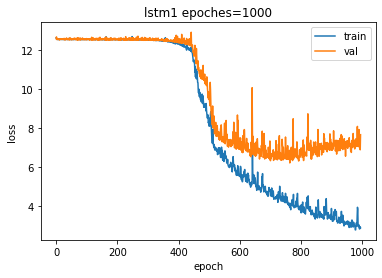

In [50]:
plt.plot(history_lstm1.history['loss'][5:])
plt.plot(history_lstm1.history['val_loss'][5:])
plt.title('lstm1 epoches=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [74]:
eval_lstm1 = model_lstm1.evaluate(X_test, y_test)
results.update({'lstm1': eval_lstm1})

12/12 [==============================] - 0s 13ms/step - loss: 6.1633 - mean_squared_error: 6.1633


#### lstm2 model, epoch=500

In [31]:
model_lstm2 = lstm2(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_lstm2.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_lstm2 = model_lstm2.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          59600     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 140,101
Trainable params: 140,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
10/10 [==============================] - 6s 305ms/step - loss: 74.7085 - mean_squared_error: 74.7085 - val_loss: 28.5470 - val_mean_squared_error: 28.5470
Epoch 2/500
10/10 

Epoch 93/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5384 - mean_squared_error: 12.5384 - val_loss: 12.5323 - val_mean_squared_error: 12.5323
Epoch 94/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5792 - mean_squared_error: 12.5792 - val_loss: 12.5407 - val_mean_squared_error: 12.5407
Epoch 95/500
10/10 [==============================] - 2s 220ms/step - loss: 12.5563 - mean_squared_error: 12.5563 - val_loss: 12.6111 - val_mean_squared_error: 12.6111
Epoch 96/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5696 - mean_squared_error: 12.5696 - val_loss: 12.5607 - val_mean_squared_error: 12.5607
Epoch 97/500
10/10 [==============================] - 2s 221ms/step - loss: 12.5449 - mean_squared_error: 12.5449 - val_loss: 12.5517 - val_mean_squared_error: 12.5517
Epoch 98/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5469 - mean_squared_error: 12.5469 - val_loss: 12.5786 - val_mean_squared_error: 

10/10 [==============================] - 2s 224ms/step - loss: 12.5598 - mean_squared_error: 12.5598 - val_loss: 12.5415 - val_mean_squared_error: 12.5415
Epoch 190/500
10/10 [==============================] - 2s 224ms/step - loss: 12.5531 - mean_squared_error: 12.5531 - val_loss: 12.5648 - val_mean_squared_error: 12.5648
Epoch 191/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5470 - mean_squared_error: 12.5470 - val_loss: 12.5382 - val_mean_squared_error: 12.5382
Epoch 192/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5546 - mean_squared_error: 12.5546 - val_loss: 12.5453 - val_mean_squared_error: 12.5453
Epoch 193/500
10/10 [==============================] - 2s 222ms/step - loss: 12.5494 - mean_squared_error: 12.5494 - val_loss: 12.5483 - val_mean_squared_error: 12.5483
Epoch 194/500
10/10 [==============================] - 2s 224ms/step - loss: 12.5998 - mean_squared_error: 12.5998 - val_loss: 12.6817 - val_mean_squared_error: 12.6817


10/10 [==============================] - 2s 223ms/step - loss: 12.4961 - mean_squared_error: 12.4961 - val_loss: 12.6322 - val_mean_squared_error: 12.6322
Epoch 286/500
10/10 [==============================] - 2s 223ms/step - loss: 12.5572 - mean_squared_error: 12.5572 - val_loss: 12.4841 - val_mean_squared_error: 12.4841
Epoch 287/500
10/10 [==============================] - 2s 224ms/step - loss: 12.5772 - mean_squared_error: 12.5772 - val_loss: 12.4913 - val_mean_squared_error: 12.4913
Epoch 288/500
10/10 [==============================] - 2s 225ms/step - loss: 12.5540 - mean_squared_error: 12.5540 - val_loss: 12.5995 - val_mean_squared_error: 12.5995
Epoch 289/500
10/10 [==============================] - 2s 231ms/step - loss: 12.5941 - mean_squared_error: 12.5941 - val_loss: 12.4771 - val_mean_squared_error: 12.4771
Epoch 290/500
10/10 [==============================] - 2s 223ms/step - loss: 12.5440 - mean_squared_error: 12.5440 - val_loss: 12.5386 - val_mean_squared_error: 12.5386


Epoch 334/500
10/10 [==============================] - 2s 222ms/step - loss: 8.0229 - mean_squared_error: 8.0229 - val_loss: 9.0920 - val_mean_squared_error: 9.0920
Epoch 335/500
10/10 [==============================] - 2s 225ms/step - loss: 7.9039 - mean_squared_error: 7.9039 - val_loss: 9.1301 - val_mean_squared_error: 9.1301
Epoch 336/500
10/10 [==============================] - 2s 223ms/step - loss: 7.9346 - mean_squared_error: 7.9346 - val_loss: 9.0123 - val_mean_squared_error: 9.0123
Epoch 337/500
10/10 [==============================] - 2s 224ms/step - loss: 7.6292 - mean_squared_error: 7.6292 - val_loss: 8.9867 - val_mean_squared_error: 8.9867
Epoch 338/500
10/10 [==============================] - 2s 223ms/step - loss: 7.7037 - mean_squared_error: 7.7037 - val_loss: 9.1065 - val_mean_squared_error: 9.1065
Epoch 339/500
10/10 [==============================] - 2s 222ms/step - loss: 7.7936 - mean_squared_error: 7.7936 - val_loss: 10.5091 - val_mean_squared_error: 10.5091
Epoch 34

Epoch 433/500
10/10 [==============================] - 2s 222ms/step - loss: 4.9118 - mean_squared_error: 4.9118 - val_loss: 7.8533 - val_mean_squared_error: 7.8533
Epoch 434/500
10/10 [==============================] - 2s 222ms/step - loss: 4.9354 - mean_squared_error: 4.9354 - val_loss: 8.0170 - val_mean_squared_error: 8.0170
Epoch 435/500
10/10 [==============================] - 2s 224ms/step - loss: 4.9805 - mean_squared_error: 4.9805 - val_loss: 7.9230 - val_mean_squared_error: 7.9230
Epoch 436/500
10/10 [==============================] - 2s 223ms/step - loss: 5.0020 - mean_squared_error: 5.0020 - val_loss: 7.4857 - val_mean_squared_error: 7.4857
Epoch 437/500
10/10 [==============================] - 2s 223ms/step - loss: 5.1978 - mean_squared_error: 5.1978 - val_loss: 8.7516 - val_mean_squared_error: 8.7516
Epoch 438/500
10/10 [==============================] - 2s 223ms/step - loss: 5.2582 - mean_squared_error: 5.2582 - val_loss: 7.6244 - val_mean_squared_error: 7.6244
Epoch 439/

Epoch 483/500
10/10 [==============================] - 2s 224ms/step - loss: 4.7519 - mean_squared_error: 4.7519 - val_loss: 7.7320 - val_mean_squared_error: 7.7320
Epoch 484/500
10/10 [==============================] - 2s 222ms/step - loss: 4.4993 - mean_squared_error: 4.4993 - val_loss: 7.3341 - val_mean_squared_error: 7.3341
Epoch 485/500
10/10 [==============================] - 2s 223ms/step - loss: 4.2696 - mean_squared_error: 4.2696 - val_loss: 7.4982 - val_mean_squared_error: 7.4982
Epoch 486/500
10/10 [==============================] - 2s 222ms/step - loss: 4.2178 - mean_squared_error: 4.2178 - val_loss: 7.1771 - val_mean_squared_error: 7.1771
Epoch 487/500
10/10 [==============================] - 2s 224ms/step - loss: 4.2370 - mean_squared_error: 4.2370 - val_loss: 7.7132 - val_mean_squared_error: 7.7132
Epoch 488/500
10/10 [==============================] - 2s 224ms/step - loss: 4.3051 - mean_squared_error: 4.3051 - val_loss: 7.7212 - val_mean_squared_error: 7.7212
Epoch 489/

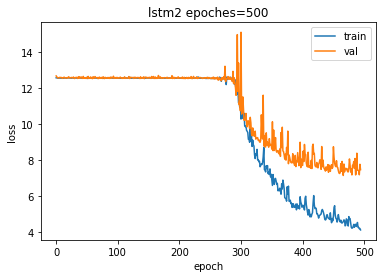

In [42]:
plt.plot(history_lstm2.history['loss'][5:])
plt.plot(history_lstm2.history['val_loss'][5:])
plt.title('lstm2 epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [77]:
eval_lstm2 = model_lstm2.evaluate(X_test, y_test)
results.update({'lstm2': eval_lstm2})

12/12 [==============================] - 0s 23ms/step - loss: 6.6242 - mean_squared_error: 6.6242


#### lstm2 model, epoch=1000

In [52]:
model_lstm2_1000 = lstm2(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_lstm2_1000.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_lstm2_1000 = model_lstm2_1000.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 100)          59600     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 140,101
Trainable params: 140,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 5s 292ms/step - loss: 83.2910 - mean_squared_error: 83.2910 - val_loss: 37.7924 - val_mean_squared_error: 37.7924
Epoch 2/1000
10/1

Epoch 44/1000
10/10 [==============================] - 2s 223ms/step - loss: 12.5481 - mean_squared_error: 12.5481 - val_loss: 12.5326 - val_mean_squared_error: 12.5326
Epoch 45/1000
10/10 [==============================] - 2s 218ms/step - loss: 12.5445 - mean_squared_error: 12.5445 - val_loss: 12.5651 - val_mean_squared_error: 12.5651
Epoch 46/1000
10/10 [==============================] - 2s 224ms/step - loss: 12.5546 - mean_squared_error: 12.5546 - val_loss: 12.5945 - val_mean_squared_error: 12.5945
Epoch 47/1000
10/10 [==============================] - 2s 217ms/step - loss: 12.5556 - mean_squared_error: 12.5556 - val_loss: 12.5712 - val_mean_squared_error: 12.5712
Epoch 48/1000
10/10 [==============================] - 2s 216ms/step - loss: 12.5577 - mean_squared_error: 12.5577 - val_loss: 12.5860 - val_mean_squared_error: 12.5860
Epoch 49/1000
10/10 [==============================] - 2s 221ms/step - loss: 12.5513 - mean_squared_error: 12.5513 - val_loss: 12.5711 - val_mean_squared_e

10/10 [==============================] - 2s 224ms/step - loss: 12.5502 - mean_squared_error: 12.5502 - val_loss: 12.5713 - val_mean_squared_error: 12.5713
Epoch 141/1000
10/10 [==============================] - 2s 227ms/step - loss: 12.5440 - mean_squared_error: 12.5440 - val_loss: 12.5551 - val_mean_squared_error: 12.5551
Epoch 142/1000
10/10 [==============================] - 2s 227ms/step - loss: 12.5526 - mean_squared_error: 12.5526 - val_loss: 12.5319 - val_mean_squared_error: 12.5319
Epoch 143/1000
10/10 [==============================] - 2s 223ms/step - loss: 12.5672 - mean_squared_error: 12.5672 - val_loss: 12.5966 - val_mean_squared_error: 12.5966
Epoch 144/1000
10/10 [==============================] - 2s 227ms/step - loss: 12.5430 - mean_squared_error: 12.5430 - val_loss: 12.5512 - val_mean_squared_error: 12.5512
Epoch 145/1000
10/10 [==============================] - 2s 227ms/step - loss: 12.5761 - mean_squared_error: 12.5761 - val_loss: 12.5267 - val_mean_squared_error: 12.

10/10 [==============================] - 2s 213ms/step - loss: 12.5415 - mean_squared_error: 12.5415 - val_loss: 12.5734 - val_mean_squared_error: 12.5734
Epoch 237/1000
10/10 [==============================] - 2s 218ms/step - loss: 12.5476 - mean_squared_error: 12.5476 - val_loss: 12.5876 - val_mean_squared_error: 12.5876
Epoch 238/1000
10/10 [==============================] - 2s 224ms/step - loss: 12.5483 - mean_squared_error: 12.5483 - val_loss: 12.5533 - val_mean_squared_error: 12.5533
Epoch 239/1000
10/10 [==============================] - 2s 225ms/step - loss: 12.5498 - mean_squared_error: 12.5498 - val_loss: 12.5420 - val_mean_squared_error: 12.5420
Epoch 240/1000
10/10 [==============================] - 2s 222ms/step - loss: 12.5326 - mean_squared_error: 12.5326 - val_loss: 12.5910 - val_mean_squared_error: 12.5910
Epoch 241/1000
10/10 [==============================] - 2s 222ms/step - loss: 12.5719 - mean_squared_error: 12.5719 - val_loss: 12.6163 - val_mean_squared_error: 12.

10/10 [==============================] - 2s 227ms/step - loss: 12.5563 - mean_squared_error: 12.5563 - val_loss: 12.5705 - val_mean_squared_error: 12.5705
Epoch 333/1000
10/10 [==============================] - 2s 225ms/step - loss: 12.5465 - mean_squared_error: 12.5465 - val_loss: 12.5597 - val_mean_squared_error: 12.5597
Epoch 334/1000
10/10 [==============================] - 2s 227ms/step - loss: 12.5677 - mean_squared_error: 12.5677 - val_loss: 12.6308 - val_mean_squared_error: 12.6308
Epoch 335/1000
10/10 [==============================] - 2s 226ms/step - loss: 12.5527 - mean_squared_error: 12.5527 - val_loss: 12.5493 - val_mean_squared_error: 12.5493
Epoch 336/1000
10/10 [==============================] - 2s 245ms/step - loss: 12.5416 - mean_squared_error: 12.5416 - val_loss: 12.5734 - val_mean_squared_error: 12.5734
Epoch 337/1000
10/10 [==============================] - 2s 229ms/step - loss: 12.5540 - mean_squared_error: 12.5540 - val_loss: 12.6031 - val_mean_squared_error: 12.

10/10 [==============================] - 2s 231ms/step - loss: 12.5040 - mean_squared_error: 12.5040 - val_loss: 12.5248 - val_mean_squared_error: 12.5248
Epoch 429/1000
10/10 [==============================] - 2s 226ms/step - loss: 12.4624 - mean_squared_error: 12.4624 - val_loss: 12.8786 - val_mean_squared_error: 12.8786
Epoch 430/1000
10/10 [==============================] - 2s 226ms/step - loss: 12.5249 - mean_squared_error: 12.5249 - val_loss: 12.5625 - val_mean_squared_error: 12.5625
Epoch 431/1000
10/10 [==============================] - 2s 229ms/step - loss: 12.7357 - mean_squared_error: 12.7357 - val_loss: 12.6506 - val_mean_squared_error: 12.6506
Epoch 432/1000
10/10 [==============================] - 2s 229ms/step - loss: 12.5530 - mean_squared_error: 12.5530 - val_loss: 12.5130 - val_mean_squared_error: 12.5130
Epoch 433/1000
10/10 [==============================] - 2s 228ms/step - loss: 12.5289 - mean_squared_error: 12.5289 - val_loss: 12.5254 - val_mean_squared_error: 12.

10/10 [==============================] - 2s 226ms/step - loss: 7.2520 - mean_squared_error: 7.2520 - val_loss: 8.8388 - val_mean_squared_error: 8.8388
Epoch 526/1000
10/10 [==============================] - 2s 226ms/step - loss: 7.0486 - mean_squared_error: 7.0486 - val_loss: 9.0907 - val_mean_squared_error: 9.0907
Epoch 527/1000
10/10 [==============================] - 2s 227ms/step - loss: 7.0782 - mean_squared_error: 7.0782 - val_loss: 8.6497 - val_mean_squared_error: 8.6497
Epoch 528/1000
10/10 [==============================] - 2s 227ms/step - loss: 7.2138 - mean_squared_error: 7.2138 - val_loss: 8.8679 - val_mean_squared_error: 8.8679
Epoch 529/1000
10/10 [==============================] - 2s 226ms/step - loss: 6.9944 - mean_squared_error: 6.9944 - val_loss: 8.7007 - val_mean_squared_error: 8.7007
Epoch 530/1000
10/10 [==============================] - 2s 226ms/step - loss: 6.9445 - mean_squared_error: 6.9445 - val_loss: 9.5250 - val_mean_squared_error: 9.5250
Epoch 531/1000
10/1

10/10 [==============================] - 2s 228ms/step - loss: 5.8352 - mean_squared_error: 5.8352 - val_loss: 7.5459 - val_mean_squared_error: 7.5459
Epoch 624/1000
10/10 [==============================] - 2s 237ms/step - loss: 4.9561 - mean_squared_error: 4.9561 - val_loss: 8.1837 - val_mean_squared_error: 8.1837
Epoch 625/1000
10/10 [==============================] - 2s 227ms/step - loss: 4.9256 - mean_squared_error: 4.9256 - val_loss: 7.3939 - val_mean_squared_error: 7.3939
Epoch 626/1000
10/10 [==============================] - 2s 230ms/step - loss: 4.7329 - mean_squared_error: 4.7329 - val_loss: 8.0676 - val_mean_squared_error: 8.0676
Epoch 627/1000
10/10 [==============================] - 2s 228ms/step - loss: 4.8335 - mean_squared_error: 4.8335 - val_loss: 7.4443 - val_mean_squared_error: 7.4443
Epoch 628/1000
10/10 [==============================] - 2s 228ms/step - loss: 4.6278 - mean_squared_error: 4.6278 - val_loss: 7.3686 - val_mean_squared_error: 7.3686
Epoch 629/1000
10/1

10/10 [==============================] - 2s 218ms/step - loss: 3.4035 - mean_squared_error: 3.4035 - val_loss: 7.7193 - val_mean_squared_error: 7.7193
Epoch 722/1000
10/10 [==============================] - 2s 217ms/step - loss: 3.6753 - mean_squared_error: 3.6753 - val_loss: 7.3751 - val_mean_squared_error: 7.3751
Epoch 723/1000
10/10 [==============================] - 2s 219ms/step - loss: 3.4922 - mean_squared_error: 3.4922 - val_loss: 7.2913 - val_mean_squared_error: 7.2913
Epoch 724/1000
10/10 [==============================] - 2s 217ms/step - loss: 3.0375 - mean_squared_error: 3.0375 - val_loss: 6.8732 - val_mean_squared_error: 6.8732
Epoch 725/1000
10/10 [==============================] - 2s 220ms/step - loss: 2.9336 - mean_squared_error: 2.9336 - val_loss: 7.5235 - val_mean_squared_error: 7.5235
Epoch 726/1000
10/10 [==============================] - 2s 218ms/step - loss: 2.9223 - mean_squared_error: 2.9223 - val_loss: 7.2400 - val_mean_squared_error: 7.2400
Epoch 727/1000
10/1

10/10 [==============================] - 2s 225ms/step - loss: 2.6449 - mean_squared_error: 2.6449 - val_loss: 6.8835 - val_mean_squared_error: 6.8835
Epoch 820/1000
10/10 [==============================] - 2s 225ms/step - loss: 2.4354 - mean_squared_error: 2.4354 - val_loss: 6.8447 - val_mean_squared_error: 6.8447
Epoch 821/1000
10/10 [==============================] - 2s 230ms/step - loss: 2.7695 - mean_squared_error: 2.7695 - val_loss: 7.2605 - val_mean_squared_error: 7.2605
Epoch 822/1000
10/10 [==============================] - 2s 226ms/step - loss: 2.6275 - mean_squared_error: 2.6275 - val_loss: 7.1039 - val_mean_squared_error: 7.1039
Epoch 823/1000
10/10 [==============================] - 2s 230ms/step - loss: 2.0548 - mean_squared_error: 2.0548 - val_loss: 7.1800 - val_mean_squared_error: 7.1800
Epoch 824/1000
10/10 [==============================] - 2s 230ms/step - loss: 2.0265 - mean_squared_error: 2.0265 - val_loss: 6.8511 - val_mean_squared_error: 6.8511
Epoch 825/1000
10/1

10/10 [==============================] - 2s 219ms/step - loss: 1.8553 - mean_squared_error: 1.8553 - val_loss: 7.0814 - val_mean_squared_error: 7.0814
Epoch 918/1000
10/10 [==============================] - 2s 230ms/step - loss: 1.4994 - mean_squared_error: 1.4994 - val_loss: 7.4932 - val_mean_squared_error: 7.4932
Epoch 919/1000
10/10 [==============================] - 2s 217ms/step - loss: 1.5136 - mean_squared_error: 1.5136 - val_loss: 7.4583 - val_mean_squared_error: 7.4583
Epoch 920/1000
10/10 [==============================] - 2s 216ms/step - loss: 1.6616 - mean_squared_error: 1.6616 - val_loss: 7.1000 - val_mean_squared_error: 7.1000
Epoch 921/1000
10/10 [==============================] - 2s 218ms/step - loss: 1.4323 - mean_squared_error: 1.4323 - val_loss: 7.1380 - val_mean_squared_error: 7.1380
Epoch 922/1000
10/10 [==============================] - 2s 217ms/step - loss: 1.3281 - mean_squared_error: 1.3281 - val_loss: 7.7813 - val_mean_squared_error: 7.7813
Epoch 923/1000
10/1

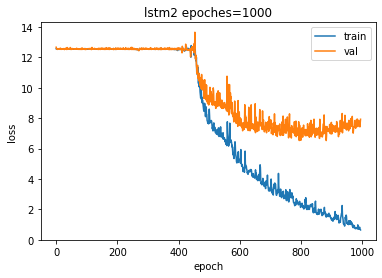

In [53]:
plt.plot(history_lstm2_1000.history['loss'][5:])
plt.plot(history_lstm2_1000.history['val_loss'][5:])
plt.title('lstm2 epoches=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [76]:
eval_lstm2_1000 = model_lstm2_1000.evaluate(X_test, y_test)
results.update({'lstm2—1000': eval_lstm2_1000})

12/12 [==============================] - 0s 24ms/step - loss: 8.5409 - mean_squared_error: 8.5409


#### blstm1 model, epoch=1000

In [56]:
model_blstm1 = blstm1(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_blstm1.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_blstm1 = model_blstm1.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              119200    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 1)                 201       
                                                                 
Total params: 119,401
Trainable params: 119,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 4s 213ms/step - loss: 75.3439 - mean_squared_error: 75.3439 - val_loss: 24.4691 - val_mean_squared_error: 24.4691
Epoch 2/1000
10/10 [==============================] - 2s 154ms/step - loss: 14.919

10/10 [==============================] - 2s 158ms/step - loss: 12.5753 - mean_squared_error: 12.5753 - val_loss: 12.5788 - val_mean_squared_error: 12.5788
Epoch 93/1000
10/10 [==============================] - 2s 154ms/step - loss: 12.5980 - mean_squared_error: 12.5980 - val_loss: 12.5760 - val_mean_squared_error: 12.5760
Epoch 94/1000
10/10 [==============================] - 2s 170ms/step - loss: 12.5236 - mean_squared_error: 12.5236 - val_loss: 12.4891 - val_mean_squared_error: 12.4891
Epoch 95/1000
10/10 [==============================] - 2s 180ms/step - loss: 12.5250 - mean_squared_error: 12.5250 - val_loss: 12.6363 - val_mean_squared_error: 12.6363
Epoch 96/1000
10/10 [==============================] - 2s 177ms/step - loss: 12.5758 - mean_squared_error: 12.5758 - val_loss: 12.4836 - val_mean_squared_error: 12.4836
Epoch 97/1000
10/10 [==============================] - 2s 162ms/step - loss: 12.5331 - mean_squared_error: 12.5331 - val_loss: 12.5123 - val_mean_squared_error: 12.5123


Epoch 189/1000
10/10 [==============================] - 2s 168ms/step - loss: 8.6756 - mean_squared_error: 8.6756 - val_loss: 9.6965 - val_mean_squared_error: 9.6965
Epoch 190/1000
10/10 [==============================] - 2s 166ms/step - loss: 8.5853 - mean_squared_error: 8.5853 - val_loss: 9.7210 - val_mean_squared_error: 9.7210
Epoch 191/1000
10/10 [==============================] - 2s 166ms/step - loss: 8.4073 - mean_squared_error: 8.4073 - val_loss: 9.3652 - val_mean_squared_error: 9.3652
Epoch 192/1000
10/10 [==============================] - 2s 167ms/step - loss: 8.5052 - mean_squared_error: 8.5052 - val_loss: 9.2615 - val_mean_squared_error: 9.2615
Epoch 193/1000
10/10 [==============================] - 2s 169ms/step - loss: 8.4026 - mean_squared_error: 8.4026 - val_loss: 10.3410 - val_mean_squared_error: 10.3410
Epoch 194/1000
10/10 [==============================] - 2s 165ms/step - loss: 8.7115 - mean_squared_error: 8.7115 - val_loss: 9.5612 - val_mean_squared_error: 9.5612
Ep

10/10 [==============================] - 2s 158ms/step - loss: 6.3430 - mean_squared_error: 6.3430 - val_loss: 9.0262 - val_mean_squared_error: 9.0262
Epoch 288/1000
10/10 [==============================] - 2s 153ms/step - loss: 6.4867 - mean_squared_error: 6.4867 - val_loss: 8.4859 - val_mean_squared_error: 8.4859
Epoch 289/1000
10/10 [==============================] - 2s 155ms/step - loss: 6.2989 - mean_squared_error: 6.2989 - val_loss: 8.8999 - val_mean_squared_error: 8.8999
Epoch 290/1000
10/10 [==============================] - 2s 155ms/step - loss: 6.5225 - mean_squared_error: 6.5225 - val_loss: 8.8852 - val_mean_squared_error: 8.8852
Epoch 291/1000
10/10 [==============================] - 2s 155ms/step - loss: 6.4083 - mean_squared_error: 6.4083 - val_loss: 8.7434 - val_mean_squared_error: 8.7434
Epoch 292/1000
10/10 [==============================] - 2s 163ms/step - loss: 6.3317 - mean_squared_error: 6.3317 - val_loss: 9.0378 - val_mean_squared_error: 9.0378
Epoch 293/1000
10/1

10/10 [==============================] - 2s 165ms/step - loss: 4.8572 - mean_squared_error: 4.8572 - val_loss: 8.3754 - val_mean_squared_error: 8.3754
Epoch 386/1000
10/10 [==============================] - 2s 170ms/step - loss: 5.0037 - mean_squared_error: 5.0037 - val_loss: 7.2495 - val_mean_squared_error: 7.2495
Epoch 387/1000
10/10 [==============================] - 2s 164ms/step - loss: 4.9969 - mean_squared_error: 4.9969 - val_loss: 7.2775 - val_mean_squared_error: 7.2775
Epoch 388/1000
10/10 [==============================] - 2s 169ms/step - loss: 4.6391 - mean_squared_error: 4.6391 - val_loss: 7.7759 - val_mean_squared_error: 7.7759
Epoch 389/1000
10/10 [==============================] - 2s 165ms/step - loss: 4.3722 - mean_squared_error: 4.3722 - val_loss: 7.2674 - val_mean_squared_error: 7.2674
Epoch 390/1000
10/10 [==============================] - 2s 167ms/step - loss: 4.4408 - mean_squared_error: 4.4408 - val_loss: 7.7711 - val_mean_squared_error: 7.7711
Epoch 391/1000
10/1

10/10 [==============================] - 2s 165ms/step - loss: 3.2825 - mean_squared_error: 3.2825 - val_loss: 7.6568 - val_mean_squared_error: 7.6568
Epoch 484/1000
10/10 [==============================] - 2s 164ms/step - loss: 3.2580 - mean_squared_error: 3.2580 - val_loss: 7.5420 - val_mean_squared_error: 7.5420
Epoch 485/1000
10/10 [==============================] - 2s 166ms/step - loss: 3.1364 - mean_squared_error: 3.1364 - val_loss: 7.5213 - val_mean_squared_error: 7.5213
Epoch 486/1000
10/10 [==============================] - 2s 165ms/step - loss: 3.0003 - mean_squared_error: 3.0003 - val_loss: 7.5446 - val_mean_squared_error: 7.5446
Epoch 487/1000
10/10 [==============================] - 2s 163ms/step - loss: 3.0826 - mean_squared_error: 3.0826 - val_loss: 7.6803 - val_mean_squared_error: 7.6803
Epoch 488/1000
10/10 [==============================] - 2s 161ms/step - loss: 3.2989 - mean_squared_error: 3.2989 - val_loss: 7.0980 - val_mean_squared_error: 7.0980
Epoch 489/1000
10/1

10/10 [==============================] - 2s 180ms/step - loss: 2.5404 - mean_squared_error: 2.5404 - val_loss: 7.8709 - val_mean_squared_error: 7.8709
Epoch 582/1000
10/10 [==============================] - 2s 167ms/step - loss: 2.5672 - mean_squared_error: 2.5672 - val_loss: 8.6592 - val_mean_squared_error: 8.6592
Epoch 583/1000
10/10 [==============================] - 2s 171ms/step - loss: 2.6178 - mean_squared_error: 2.6178 - val_loss: 8.0391 - val_mean_squared_error: 8.0391
Epoch 584/1000
10/10 [==============================] - 2s 168ms/step - loss: 2.4020 - mean_squared_error: 2.4020 - val_loss: 8.1268 - val_mean_squared_error: 8.1268
Epoch 585/1000
10/10 [==============================] - 2s 171ms/step - loss: 2.6809 - mean_squared_error: 2.6809 - val_loss: 8.0480 - val_mean_squared_error: 8.0480
Epoch 586/1000
10/10 [==============================] - 2s 168ms/step - loss: 2.5844 - mean_squared_error: 2.5844 - val_loss: 8.2046 - val_mean_squared_error: 8.2046
Epoch 587/1000
10/1

10/10 [==============================] - 2s 161ms/step - loss: 1.5699 - mean_squared_error: 1.5699 - val_loss: 8.4746 - val_mean_squared_error: 8.4746
Epoch 680/1000
10/10 [==============================] - 2s 161ms/step - loss: 1.5514 - mean_squared_error: 1.5514 - val_loss: 7.9482 - val_mean_squared_error: 7.9482
Epoch 681/1000
10/10 [==============================] - 2s 164ms/step - loss: 1.5211 - mean_squared_error: 1.5211 - val_loss: 8.4843 - val_mean_squared_error: 8.4843
Epoch 682/1000
10/10 [==============================] - 2s 164ms/step - loss: 1.4928 - mean_squared_error: 1.4928 - val_loss: 8.4424 - val_mean_squared_error: 8.4424
Epoch 683/1000
10/10 [==============================] - 2s 165ms/step - loss: 1.5628 - mean_squared_error: 1.5628 - val_loss: 8.3732 - val_mean_squared_error: 8.3732
Epoch 684/1000
10/10 [==============================] - 2s 162ms/step - loss: 1.6744 - mean_squared_error: 1.6744 - val_loss: 8.2292 - val_mean_squared_error: 8.2292
Epoch 685/1000
10/1

10/10 [==============================] - 2s 164ms/step - loss: 1.1253 - mean_squared_error: 1.1253 - val_loss: 8.3238 - val_mean_squared_error: 8.3238
Epoch 778/1000
10/10 [==============================] - 2s 162ms/step - loss: 0.9532 - mean_squared_error: 0.9532 - val_loss: 8.6523 - val_mean_squared_error: 8.6523
Epoch 779/1000
10/10 [==============================] - 2s 161ms/step - loss: 0.8781 - mean_squared_error: 0.8781 - val_loss: 8.4156 - val_mean_squared_error: 8.4156
Epoch 780/1000
10/10 [==============================] - 2s 164ms/step - loss: 0.8026 - mean_squared_error: 0.8026 - val_loss: 8.6962 - val_mean_squared_error: 8.6962
Epoch 781/1000
10/10 [==============================] - 2s 163ms/step - loss: 0.8037 - mean_squared_error: 0.8037 - val_loss: 8.7554 - val_mean_squared_error: 8.7554
Epoch 782/1000
10/10 [==============================] - 2s 163ms/step - loss: 0.7720 - mean_squared_error: 0.7720 - val_loss: 8.2251 - val_mean_squared_error: 8.2251
Epoch 783/1000
10/1

10/10 [==============================] - 2s 166ms/step - loss: 0.4033 - mean_squared_error: 0.4033 - val_loss: 8.8927 - val_mean_squared_error: 8.8927
Epoch 876/1000
10/10 [==============================] - 2s 165ms/step - loss: 0.3999 - mean_squared_error: 0.3999 - val_loss: 8.9036 - val_mean_squared_error: 8.9036
Epoch 877/1000
10/10 [==============================] - 2s 166ms/step - loss: 0.4026 - mean_squared_error: 0.4026 - val_loss: 8.7627 - val_mean_squared_error: 8.7627
Epoch 878/1000
10/10 [==============================] - 2s 164ms/step - loss: 0.4379 - mean_squared_error: 0.4379 - val_loss: 9.3405 - val_mean_squared_error: 9.3405
Epoch 879/1000
10/10 [==============================] - 2s 167ms/step - loss: 0.4249 - mean_squared_error: 0.4249 - val_loss: 9.0303 - val_mean_squared_error: 9.0303
Epoch 880/1000
10/10 [==============================] - 2s 164ms/step - loss: 0.4005 - mean_squared_error: 0.4005 - val_loss: 8.9254 - val_mean_squared_error: 8.9254
Epoch 881/1000
10/1

10/10 [==============================] - 2s 165ms/step - loss: 0.1555 - mean_squared_error: 0.1555 - val_loss: 9.2264 - val_mean_squared_error: 9.2264
Epoch 974/1000
10/10 [==============================] - 2s 164ms/step - loss: 0.1672 - mean_squared_error: 0.1672 - val_loss: 9.0508 - val_mean_squared_error: 9.0508
Epoch 975/1000
10/10 [==============================] - 2s 168ms/step - loss: 0.1646 - mean_squared_error: 0.1646 - val_loss: 9.1573 - val_mean_squared_error: 9.1573
Epoch 976/1000
10/10 [==============================] - 2s 168ms/step - loss: 0.2238 - mean_squared_error: 0.2238 - val_loss: 9.3673 - val_mean_squared_error: 9.3673
Epoch 977/1000
10/10 [==============================] - 2s 165ms/step - loss: 0.3143 - mean_squared_error: 0.3143 - val_loss: 9.2936 - val_mean_squared_error: 9.2936
Epoch 978/1000
10/10 [==============================] - 2s 161ms/step - loss: 0.3331 - mean_squared_error: 0.3331 - val_loss: 9.3533 - val_mean_squared_error: 9.3533
Epoch 979/1000
10/1

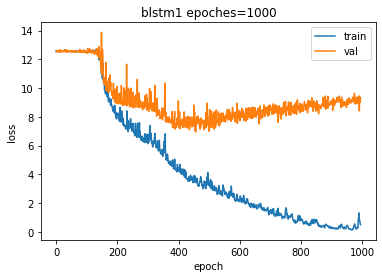

In [57]:
plt.plot(history_blstm1.history['loss'][5:])
plt.plot(history_blstm1.history['val_loss'][5:])
plt.title('blstm1 epoches=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [58]:
eval_blstm1 = model_blstm1.evaluate(X_test, y_test)
results.update({'blstm1': eval_blstm1})

12/12 [==============================] - 0s 15ms/step - loss: 8.6764 - mean_squared_error: 8.6764


#### blstm2 model, epoch=1000

In [59]:
model_blstm2 = blstm2(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_blstm2.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_blstm2 = model_blstm2.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 200)         119200    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_19 (Dense)            (None, 1)                 201       
                                                                 
Total params: 360,201
Trainable params: 360,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] 

10/10 [==============================] - 4s 434ms/step - loss: 12.4586 - mean_squared_error: 12.4586 - val_loss: 12.3954 - val_mean_squared_error: 12.3954
Epoch 92/1000
10/10 [==============================] - 4s 431ms/step - loss: 12.5303 - mean_squared_error: 12.5303 - val_loss: 13.0817 - val_mean_squared_error: 13.0817
Epoch 93/1000
10/10 [==============================] - 4s 431ms/step - loss: 12.7019 - mean_squared_error: 12.7019 - val_loss: 12.5456 - val_mean_squared_error: 12.5456
Epoch 94/1000
10/10 [==============================] - 4s 437ms/step - loss: 12.6150 - mean_squared_error: 12.6150 - val_loss: 12.6490 - val_mean_squared_error: 12.6490
Epoch 95/1000
10/10 [==============================] - 4s 436ms/step - loss: 12.4730 - mean_squared_error: 12.4730 - val_loss: 12.3989 - val_mean_squared_error: 12.3989
Epoch 96/1000
10/10 [==============================] - 4s 430ms/step - loss: 12.4178 - mean_squared_error: 12.4178 - val_loss: 12.4557 - val_mean_squared_error: 12.4557


10/10 [==============================] - 4s 439ms/step - loss: 5.1387 - mean_squared_error: 5.1387 - val_loss: 7.8358 - val_mean_squared_error: 7.8358
Epoch 189/1000
10/10 [==============================] - 4s 438ms/step - loss: 4.9816 - mean_squared_error: 4.9816 - val_loss: 7.5238 - val_mean_squared_error: 7.5238
Epoch 190/1000
10/10 [==============================] - 5s 473ms/step - loss: 4.6441 - mean_squared_error: 4.6441 - val_loss: 7.8577 - val_mean_squared_error: 7.8577
Epoch 191/1000
10/10 [==============================] - 4s 443ms/step - loss: 4.9704 - mean_squared_error: 4.9704 - val_loss: 7.9380 - val_mean_squared_error: 7.9380
Epoch 192/1000
10/10 [==============================] - 4s 441ms/step - loss: 5.1501 - mean_squared_error: 5.1501 - val_loss: 8.0530 - val_mean_squared_error: 8.0530
Epoch 193/1000
10/10 [==============================] - 4s 433ms/step - loss: 4.8297 - mean_squared_error: 4.8297 - val_loss: 8.1400 - val_mean_squared_error: 8.1400
Epoch 194/1000
10/1

10/10 [==============================] - 4s 422ms/step - loss: 3.1197 - mean_squared_error: 3.1197 - val_loss: 7.7097 - val_mean_squared_error: 7.7097
Epoch 287/1000
10/10 [==============================] - 4s 414ms/step - loss: 3.0586 - mean_squared_error: 3.0586 - val_loss: 7.8723 - val_mean_squared_error: 7.8723
Epoch 288/1000
10/10 [==============================] - 4s 423ms/step - loss: 2.9013 - mean_squared_error: 2.9013 - val_loss: 8.2176 - val_mean_squared_error: 8.2176
Epoch 289/1000
10/10 [==============================] - 4s 421ms/step - loss: 2.9437 - mean_squared_error: 2.9437 - val_loss: 7.5209 - val_mean_squared_error: 7.5209
Epoch 290/1000
10/10 [==============================] - 4s 414ms/step - loss: 3.0537 - mean_squared_error: 3.0537 - val_loss: 7.7069 - val_mean_squared_error: 7.7069
Epoch 291/1000
10/10 [==============================] - 4s 420ms/step - loss: 2.9292 - mean_squared_error: 2.9292 - val_loss: 7.3403 - val_mean_squared_error: 7.3403
Epoch 292/1000
10/1

10/10 [==============================] - 4s 422ms/step - loss: 1.5143 - mean_squared_error: 1.5143 - val_loss: 8.8121 - val_mean_squared_error: 8.8121
Epoch 385/1000
10/10 [==============================] - 4s 433ms/step - loss: 1.2951 - mean_squared_error: 1.2951 - val_loss: 9.1614 - val_mean_squared_error: 9.1614
Epoch 386/1000
10/10 [==============================] - 4s 423ms/step - loss: 1.2781 - mean_squared_error: 1.2781 - val_loss: 8.8650 - val_mean_squared_error: 8.8650
Epoch 387/1000
10/10 [==============================] - 4s 416ms/step - loss: 1.3053 - mean_squared_error: 1.3053 - val_loss: 8.8078 - val_mean_squared_error: 8.8078
Epoch 388/1000
10/10 [==============================] - 4s 422ms/step - loss: 1.3993 - mean_squared_error: 1.3993 - val_loss: 8.7159 - val_mean_squared_error: 8.7159
Epoch 389/1000
10/10 [==============================] - 4s 430ms/step - loss: 1.3701 - mean_squared_error: 1.3701 - val_loss: 9.2506 - val_mean_squared_error: 9.2506
Epoch 390/1000
10/1

10/10 [==============================] - 4s 419ms/step - loss: 0.4726 - mean_squared_error: 0.4726 - val_loss: 9.8175 - val_mean_squared_error: 9.8175
Epoch 483/1000
10/10 [==============================] - 4s 413ms/step - loss: 0.4388 - mean_squared_error: 0.4388 - val_loss: 9.7297 - val_mean_squared_error: 9.7297
Epoch 484/1000
10/10 [==============================] - 4s 419ms/step - loss: 0.4483 - mean_squared_error: 0.4483 - val_loss: 9.6735 - val_mean_squared_error: 9.6735
Epoch 485/1000
10/10 [==============================] - 4s 416ms/step - loss: 0.4762 - mean_squared_error: 0.4762 - val_loss: 9.2974 - val_mean_squared_error: 9.2974
Epoch 486/1000
10/10 [==============================] - 4s 417ms/step - loss: 0.4191 - mean_squared_error: 0.4191 - val_loss: 9.4370 - val_mean_squared_error: 9.4370
Epoch 487/1000
10/10 [==============================] - 4s 424ms/step - loss: 0.3680 - mean_squared_error: 0.3680 - val_loss: 9.5934 - val_mean_squared_error: 9.5934
Epoch 488/1000
10/1

10/10 [==============================] - 4s 405ms/step - loss: 0.2246 - mean_squared_error: 0.2246 - val_loss: 9.4492 - val_mean_squared_error: 9.4492
Epoch 581/1000
10/10 [==============================] - 4s 413ms/step - loss: 0.2095 - mean_squared_error: 0.2095 - val_loss: 9.2698 - val_mean_squared_error: 9.2698
Epoch 582/1000
10/10 [==============================] - 4s 403ms/step - loss: 0.1319 - mean_squared_error: 0.1319 - val_loss: 9.6585 - val_mean_squared_error: 9.6585
Epoch 583/1000
10/10 [==============================] - 4s 407ms/step - loss: 0.1144 - mean_squared_error: 0.1144 - val_loss: 9.6259 - val_mean_squared_error: 9.6259
Epoch 584/1000
10/10 [==============================] - 4s 406ms/step - loss: 0.1279 - mean_squared_error: 0.1279 - val_loss: 9.5230 - val_mean_squared_error: 9.5230
Epoch 585/1000
10/10 [==============================] - 4s 403ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 9.5187 - val_mean_squared_error: 9.5187
Epoch 586/1000
10/1

10/10 [==============================] - 4s 412ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 9.6211 - val_mean_squared_error: 9.6211
Epoch 679/1000
10/10 [==============================] - 4s 411ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 9.4663 - val_mean_squared_error: 9.4663
Epoch 680/1000
10/10 [==============================] - 4s 405ms/step - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 9.4308 - val_mean_squared_error: 9.4308
Epoch 681/1000
10/10 [==============================] - 4s 411ms/step - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 9.6825 - val_mean_squared_error: 9.6825
Epoch 682/1000
10/10 [==============================] - 4s 403ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 9.9032 - val_mean_squared_error: 9.9032
Epoch 683/1000
10/10 [==============================] - 4s 410ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - val_loss: 9.5689 - val_mean_squared_error: 9.5689
Epoch 684/1000
10/1

10/10 [==============================] - 4s 411ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 9.3177 - val_mean_squared_error: 9.3177
Epoch 777/1000
10/10 [==============================] - 4s 406ms/step - loss: 0.0845 - mean_squared_error: 0.0845 - val_loss: 9.1781 - val_mean_squared_error: 9.1781
Epoch 778/1000
10/10 [==============================] - 4s 407ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - val_loss: 9.4656 - val_mean_squared_error: 9.4656
Epoch 779/1000
10/10 [==============================] - 4s 415ms/step - loss: 0.0841 - mean_squared_error: 0.0841 - val_loss: 9.2582 - val_mean_squared_error: 9.2582
Epoch 780/1000
10/10 [==============================] - 4s 405ms/step - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 9.4846 - val_mean_squared_error: 9.4846
Epoch 781/1000
10/10 [==============================] - 4s 412ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 9.1954 - val_mean_squared_error: 9.1954
Epoch 782/1000
10/1

10/10 [==============================] - 4s 414ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - val_loss: 9.2961 - val_mean_squared_error: 9.2961
Epoch 875/1000
10/10 [==============================] - 4s 405ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 9.2711 - val_mean_squared_error: 9.2711
Epoch 876/1000
10/10 [==============================] - 4s 408ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 9.0981 - val_mean_squared_error: 9.0981
Epoch 877/1000
10/10 [==============================] - 4s 408ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 9.1694 - val_mean_squared_error: 9.1694
Epoch 878/1000
10/10 [==============================] - 4s 405ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 9.1883 - val_mean_squared_error: 9.1883
Epoch 879/1000
10/10 [==============================] - 4s 413ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 9.0006 - val_mean_squared_error: 9.0006
Epoch 880/1000
10/1

10/10 [==============================] - 4s 416ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 9.0719 - val_mean_squared_error: 9.0719
Epoch 973/1000
10/10 [==============================] - 4s 414ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 9.4030 - val_mean_squared_error: 9.4030
Epoch 974/1000
10/10 [==============================] - 4s 412ms/step - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 9.0756 - val_mean_squared_error: 9.0756
Epoch 975/1000
10/10 [==============================] - 4s 406ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 9.0372 - val_mean_squared_error: 9.0372
Epoch 976/1000
10/10 [==============================] - 4s 415ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 9.0672 - val_mean_squared_error: 9.0672
Epoch 977/1000
10/10 [==============================] - 4s 402ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 9.1648 - val_mean_squared_error: 9.1648
Epoch 978/1000
10/1

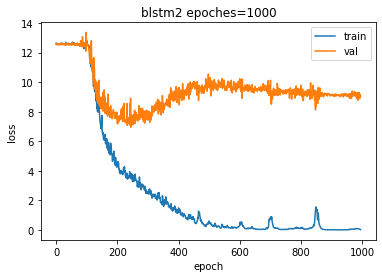

In [60]:
plt.plot(history_blstm2.history['loss'][5:])
plt.plot(history_blstm2.history['val_loss'][5:])
plt.title('blstm2 epoches=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [61]:
eval_blstm2 = model_blstm2.evaluate(X_test, y_test)
results.update({'blstm2': eval_blstm2})

12/12 [==============================] - 0s 37ms/step - loss: 7.3103 - mean_squared_error: 7.3103


#### lstm_fcn model, epoch=100

In [65]:
model_lstm_fcn = lstm_fcn(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_lstm_fcn.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_lstm_fcn = model_lstm_fcn.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100, 48)]    0           []                               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 100, 128)     49280       ['input_15[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 100, 128)    512         ['conv1d_17[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 100, 128)     0           ['batch_normalization_3[0]

10/10 [==============================] - 2s 193ms/step - loss: 1.1208 - mean_squared_error: 1.1208 - val_loss: 26.1834 - val_mean_squared_error: 26.1834
Epoch 74/500
10/10 [==============================] - 2s 195ms/step - loss: 0.8963 - mean_squared_error: 0.8963 - val_loss: 16.0784 - val_mean_squared_error: 16.0784
Epoch 75/500
10/10 [==============================] - 2s 198ms/step - loss: 0.8801 - mean_squared_error: 0.8801 - val_loss: 30.6735 - val_mean_squared_error: 30.6735
Epoch 76/500
10/10 [==============================] - 2s 191ms/step - loss: 0.8926 - mean_squared_error: 0.8926 - val_loss: 13.7120 - val_mean_squared_error: 13.7120
Epoch 77/500
10/10 [==============================] - 2s 194ms/step - loss: 0.7538 - mean_squared_error: 0.7538 - val_loss: 18.2551 - val_mean_squared_error: 18.2551
Epoch 78/500
10/10 [==============================] - 2s 198ms/step - loss: 1.0697 - mean_squared_error: 1.0697 - val_loss: 14.6595 - val_mean_squared_error: 14.6595
Epoch 79/500
10/1

10/10 [==============================] - 2s 197ms/step - loss: 0.3148 - mean_squared_error: 0.3148 - val_loss: 31.0463 - val_mean_squared_error: 31.0463
Epoch 172/500
10/10 [==============================] - 2s 203ms/step - loss: 0.3575 - mean_squared_error: 0.3575 - val_loss: 23.2052 - val_mean_squared_error: 23.2052
Epoch 173/500
10/10 [==============================] - 2s 201ms/step - loss: 0.2939 - mean_squared_error: 0.2939 - val_loss: 13.7391 - val_mean_squared_error: 13.7391
Epoch 174/500
10/10 [==============================] - 2s 197ms/step - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 14.6702 - val_mean_squared_error: 14.6702
Epoch 175/500
10/10 [==============================] - 2s 193ms/step - loss: 0.2745 - mean_squared_error: 0.2745 - val_loss: 16.2909 - val_mean_squared_error: 16.2909
Epoch 176/500
10/10 [==============================] - 2s 198ms/step - loss: 0.1999 - mean_squared_error: 0.1999 - val_loss: 8.6529 - val_mean_squared_error: 8.6529
Epoch 177/500


10/10 [==============================] - 2s 193ms/step - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 9.1753 - val_mean_squared_error: 9.1753
Epoch 270/500
10/10 [==============================] - 2s 196ms/step - loss: 0.2820 - mean_squared_error: 0.2820 - val_loss: 7.7204 - val_mean_squared_error: 7.7204
Epoch 271/500
10/10 [==============================] - 2s 198ms/step - loss: 0.3064 - mean_squared_error: 0.3064 - val_loss: 10.4423 - val_mean_squared_error: 10.4423
Epoch 272/500
10/10 [==============================] - 2s 192ms/step - loss: 0.2189 - mean_squared_error: 0.2189 - val_loss: 18.2898 - val_mean_squared_error: 18.2898
Epoch 273/500
10/10 [==============================] - 2s 193ms/step - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 8.1350 - val_mean_squared_error: 8.1350
Epoch 274/500
10/10 [==============================] - 2s 199ms/step - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 7.5734 - val_mean_squared_error: 7.5734
Epoch 275/500
10/10 

10/10 [==============================] - 2s 192ms/step - loss: 0.1320 - mean_squared_error: 0.1320 - val_loss: 7.6533 - val_mean_squared_error: 7.6533
Epoch 368/500
10/10 [==============================] - 2s 187ms/step - loss: 0.1849 - mean_squared_error: 0.1849 - val_loss: 20.5783 - val_mean_squared_error: 20.5783
Epoch 369/500
10/10 [==============================] - 2s 192ms/step - loss: 0.1394 - mean_squared_error: 0.1394 - val_loss: 11.7665 - val_mean_squared_error: 11.7665
Epoch 370/500
10/10 [==============================] - 2s 193ms/step - loss: 0.1740 - mean_squared_error: 0.1740 - val_loss: 17.5794 - val_mean_squared_error: 17.5794
Epoch 371/500
10/10 [==============================] - 2s 190ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 11.7544 - val_mean_squared_error: 11.7544
Epoch 372/500
10/10 [==============================] - 2s 187ms/step - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 7.9284 - val_mean_squared_error: 7.9284
Epoch 373/500
10

10/10 [==============================] - 2s 192ms/step - loss: 0.2040 - mean_squared_error: 0.2040 - val_loss: 15.1728 - val_mean_squared_error: 15.1728
Epoch 466/500
10/10 [==============================] - 2s 189ms/step - loss: 0.1434 - mean_squared_error: 0.1434 - val_loss: 9.9368 - val_mean_squared_error: 9.9368
Epoch 467/500
10/10 [==============================] - 2s 191ms/step - loss: 0.2333 - mean_squared_error: 0.2333 - val_loss: 9.1438 - val_mean_squared_error: 9.1438
Epoch 468/500
10/10 [==============================] - 2s 193ms/step - loss: 0.1403 - mean_squared_error: 0.1403 - val_loss: 8.8260 - val_mean_squared_error: 8.8260
Epoch 469/500
10/10 [==============================] - 2s 190ms/step - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 10.3622 - val_mean_squared_error: 10.3622
Epoch 470/500
10/10 [==============================] - 2s 190ms/step - loss: 0.1582 - mean_squared_error: 0.1582 - val_loss: 11.3673 - val_mean_squared_error: 11.3673
Epoch 471/500
10/1

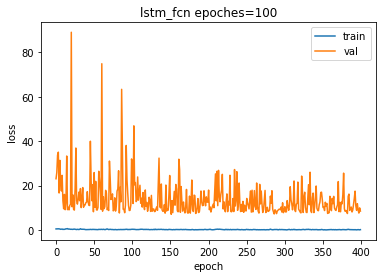

In [69]:
plt.plot(history_lstm_fcn.history['loss'][100:])
plt.plot(history_lstm_fcn.history['val_loss'][100:])
plt.title('lstm_fcn epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [67]:
eval_lstm_fcn = model_lstm_fcn.evaluate(X_test, y_test)
results.update({'lstm_fcn': eval_lstm_fcn})

12/12 [==============================] - 0s 15ms/step - loss: 6.8699 - mean_squared_error: 6.8699


#### ResNet, epoch=100

In [70]:
model_resnet = cnn_resnet(input_shape=(100, 48), n_classes=1, output_activation=None, verbose=True)
model_resnet.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
history_resnet = model_resnet.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 100, 48)]    0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 100, 64)      24640       ['input_16[0][0]']               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 100, 64)     256         ['conv1d_20[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 100, 64)      0           ['batch_normalization_6[0]

10/10 [==============================] - 6s 358ms/step - loss: 102.2360 - mean_squared_error: 102.2360 - val_loss: 107.5316 - val_mean_squared_error: 107.5316
Epoch 2/500
10/10 [==============================] - 4s 373ms/step - loss: 55.0723 - mean_squared_error: 55.0723 - val_loss: 102.3315 - val_mean_squared_error: 102.3315
Epoch 3/500
10/10 [==============================] - 4s 352ms/step - loss: 38.0187 - mean_squared_error: 38.0187 - val_loss: 81.0777 - val_mean_squared_error: 81.0777
Epoch 4/500
10/10 [==============================] - 4s 364ms/step - loss: 27.4369 - mean_squared_error: 27.4369 - val_loss: 70.2671 - val_mean_squared_error: 70.2671
Epoch 5/500
10/10 [==============================] - 4s 369ms/step - loss: 19.9382 - mean_squared_error: 19.9382 - val_loss: 49.8097 - val_mean_squared_error: 49.8097
Epoch 6/500
10/10 [==============================] - 4s 382ms/step - loss: 14.3377 - mean_squared_error: 14.3377 - val_loss: 50.9172 - val_mean_squared_error: 50.9172
Epoc

Epoch 100/500
10/10 [==============================] - 3s 326ms/step - loss: 0.2978 - mean_squared_error: 0.2978 - val_loss: 9.5796 - val_mean_squared_error: 9.5796
Epoch 101/500
10/10 [==============================] - 3s 319ms/step - loss: 0.3226 - mean_squared_error: 0.3226 - val_loss: 9.2484 - val_mean_squared_error: 9.2484
Epoch 102/500
10/10 [==============================] - 3s 330ms/step - loss: 0.2241 - mean_squared_error: 0.2241 - val_loss: 8.7551 - val_mean_squared_error: 8.7551
Epoch 103/500
10/10 [==============================] - 3s 315ms/step - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 8.2860 - val_mean_squared_error: 8.2860
Epoch 104/500
10/10 [==============================] - 3s 316ms/step - loss: 0.2218 - mean_squared_error: 0.2218 - val_loss: 7.8602 - val_mean_squared_error: 7.8602
Epoch 105/500
10/10 [==============================] - 3s 307ms/step - loss: 0.2815 - mean_squared_error: 0.2815 - val_loss: 8.3391 - val_mean_squared_error: 8.3391
Epoch 106/

10/10 [==============================] - 3s 311ms/step - loss: 0.2994 - mean_squared_error: 0.2994 - val_loss: 8.2919 - val_mean_squared_error: 8.2919
Epoch 199/500
10/10 [==============================] - 3s 310ms/step - loss: 0.2284 - mean_squared_error: 0.2284 - val_loss: 9.9645 - val_mean_squared_error: 9.9645
Epoch 200/500
10/10 [==============================] - 3s 308ms/step - loss: 0.1726 - mean_squared_error: 0.1726 - val_loss: 9.0358 - val_mean_squared_error: 9.0358
Epoch 201/500
10/10 [==============================] - 3s 308ms/step - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 8.2896 - val_mean_squared_error: 8.2896
Epoch 202/500
10/10 [==============================] - 3s 308ms/step - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 10.8630 - val_mean_squared_error: 10.8630
Epoch 203/500
10/10 [==============================] - 3s 304ms/step - loss: 0.3390 - mean_squared_error: 0.3390 - val_loss: 8.1551 - val_mean_squared_error: 8.1551
Epoch 204/500
10/10 [=

Epoch 248/500
10/10 [==============================] - 3s 307ms/step - loss: 0.1888 - mean_squared_error: 0.1888 - val_loss: 9.2654 - val_mean_squared_error: 9.2654
Epoch 249/500
10/10 [==============================] - 3s 329ms/step - loss: 0.1692 - mean_squared_error: 0.1692 - val_loss: 8.2058 - val_mean_squared_error: 8.2058
Epoch 250/500
10/10 [==============================] - 3s 319ms/step - loss: 0.1938 - mean_squared_error: 0.1938 - val_loss: 7.7229 - val_mean_squared_error: 7.7229
Epoch 251/500
10/10 [==============================] - 3s 310ms/step - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 7.5116 - val_mean_squared_error: 7.5116
Epoch 252/500
10/10 [==============================] - 3s 311ms/step - loss: 0.1923 - mean_squared_error: 0.1923 - val_loss: 7.7963 - val_mean_squared_error: 7.7963
Epoch 253/500
10/10 [==============================] - 3s 310ms/step - loss: 0.1886 - mean_squared_error: 0.1886 - val_loss: 7.6419 - val_mean_squared_error: 7.6419
Epoch 254/

Epoch 347/500
10/10 [==============================] - 3s 322ms/step - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 7.5725 - val_mean_squared_error: 7.5725
Epoch 348/500
10/10 [==============================] - 4s 354ms/step - loss: 0.1826 - mean_squared_error: 0.1826 - val_loss: 6.9789 - val_mean_squared_error: 6.9789
Epoch 349/500
10/10 [==============================] - 4s 358ms/step - loss: 0.1762 - mean_squared_error: 0.1762 - val_loss: 7.6218 - val_mean_squared_error: 7.6218
Epoch 350/500
10/10 [==============================] - 3s 311ms/step - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 8.5067 - val_mean_squared_error: 8.5067
Epoch 351/500
10/10 [==============================] - 3s 348ms/step - loss: 0.1733 - mean_squared_error: 0.1733 - val_loss: 8.2946 - val_mean_squared_error: 8.2946
Epoch 352/500
10/10 [==============================] - 3s 317ms/step - loss: 0.2159 - mean_squared_error: 0.2159 - val_loss: 7.4457 - val_mean_squared_error: 7.4457
Epoch 353/

Epoch 446/500
10/10 [==============================] - 3s 321ms/step - loss: 0.1992 - mean_squared_error: 0.1992 - val_loss: 7.5921 - val_mean_squared_error: 7.5921
Epoch 447/500
10/10 [==============================] - 3s 314ms/step - loss: 0.1744 - mean_squared_error: 0.1744 - val_loss: 7.3635 - val_mean_squared_error: 7.3635
Epoch 448/500
10/10 [==============================] - 3s 318ms/step - loss: 0.2879 - mean_squared_error: 0.2879 - val_loss: 9.7488 - val_mean_squared_error: 9.7488
Epoch 449/500
10/10 [==============================] - 3s 331ms/step - loss: 0.2276 - mean_squared_error: 0.2276 - val_loss: 7.9574 - val_mean_squared_error: 7.9574
Epoch 450/500
10/10 [==============================] - 3s 339ms/step - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 8.3194 - val_mean_squared_error: 8.3194
Epoch 451/500
10/10 [==============================] - 3s 322ms/step - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 7.6072 - val_mean_squared_error: 7.6072
Epoch 452/

Epoch 496/500
10/10 [==============================] - 3s 317ms/step - loss: 0.2816 - mean_squared_error: 0.2816 - val_loss: 7.1227 - val_mean_squared_error: 7.1227
Epoch 497/500
10/10 [==============================] - 3s 320ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - val_loss: 8.7369 - val_mean_squared_error: 8.7369
Epoch 498/500
10/10 [==============================] - 3s 314ms/step - loss: 0.1317 - mean_squared_error: 0.1317 - val_loss: 7.2558 - val_mean_squared_error: 7.2558
Epoch 499/500
10/10 [==============================] - 3s 323ms/step - loss: 0.1701 - mean_squared_error: 0.1701 - val_loss: 9.9510 - val_mean_squared_error: 9.9510
Epoch 500/500
10/10 [==============================] - 3s 321ms/step - loss: 0.2124 - mean_squared_error: 0.2124 - val_loss: 8.2666 - val_mean_squared_error: 8.2666


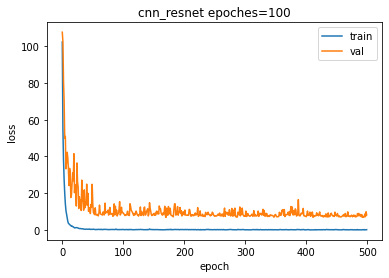

In [71]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('cnn_resnet epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [72]:
eval_resnet = model_resnet.evaluate(X_test, y_test)
results.update({'resnet': eval_resnet})

12/12 [==============================] - 0s 19ms/step - loss: 6.9365 - mean_squared_error: 6.9365


In [78]:
results

{'cnn_lenet': [9.026124000549316, 9.026124000549316],
 'mlp4': [12.182729721069336, 12.182729721069336],
 'vgg': [6.335491180419922, 6.335491180419922],
 'lstm1v0': [6.487916469573975, 6.487916469573975],
 'lstm1': [6.163276195526123, 6.163276195526123],
 'lstm2': [6.62415885925293, 6.62415885925293],
 'blstm1': [8.676371574401855, 8.676371574401855],
 'lstm1v0——epoch=1000': [6.50009822845459, 6.50009822845459],
 'blstm2': [7.31030797958374, 7.31030797958374],
 'lstm_fcn': [6.8698577880859375, 6.8698577880859375],
 'resnet': [6.936489582061768, 6.936489582061768],
 'lstm2—1000': [8.540902137756348, 8.540902137756348]}